In [3]:
print("lets get training , first we will build the model then load the data and then test it")
import socket
_orig_getaddrinfo = socket.getaddrinfo
def _ipv4_only(host, port, family=0, type=0, proto=0, flags=0):
    return _orig_getaddrinfo(host, port, socket.AF_INET, type, proto, flags)
socket.getaddrinfo = _ipv4_only


lets get training , first we will build the model then load the data and then test it


# Lets get started !

### Step 0 load the NN model architecture 

In [4]:
# step 0 load the Neural network / model architecture

#!/usr/bin/env python3
"""
TCN (Temporal Convolutional Network) for Audio-to-Blendshapes
Real-time causal model for audio to facial animation
UPDATED: 10+ seconds receptive field for personality and context modeling
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class DepthwiseSeparableConv1d(nn.Module):
    """
    Depthwise Separable Convolution for efficiency
    """
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, padding=0):
        super().__init__()
        
        # Depthwise convolution
        self.depthwise = nn.Conv1d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            dilation=dilation,
            padding=padding,
            groups=in_channels,  # Key: groups=in_channels makes it depthwise
            bias=False
        )
        
        # Pointwise convolution
        self.pointwise = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            bias=False
        )
        
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
    
    def forward(self, x):
        x = self.bn1(self.depthwise(x))
        x = self.bn2(self.pointwise(x))
        return x

class TCNBlock(nn.Module):
    """
    Single TCN block with dilated causal convolution
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, dropout=0.1):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.dilation = dilation
        
        # Calculate padding for causal convolution (no future information)
        self.padding = (kernel_size - 1) * dilation
        
        # Depthwise separable convolution
        self.conv = DepthwiseSeparableConv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            dilation=dilation,
            padding=self.padding
        )
        
        # Activation and normalization
        self.activation = nn.GELU()  # GELU as recommended
        self.dropout = nn.Dropout(dropout)
        
        # Residual connection
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        
    def forward(self, x):
        """
        Forward pass with causal convolution
        
        Args:
            x: Input tensor of shape (batch, channels, time)
        
        Returns:
            Output tensor of shape (batch, channels, time)
        """
        residual = x
        
        # Apply convolution with causal padding
        out = self.conv(x)
        
        # Remove future information (causal)
        if self.padding > 0:
            out = out[:, :, :-self.padding]
        
        out = self.activation(out)
        out = self.dropout(out)
        
        # Residual connection
        if self.residual_conv is not None:
            residual = self.residual_conv(residual)
        
        # Ensure same sequence length for residual connection
        if residual.size(2) != out.size(2):
            min_len = min(residual.size(2), out.size(2))
            residual = residual[:, :, :min_len]
            out = out[:, :, :min_len]
        
        return out + residual

class AudioToBlendshapesTCN(nn.Module):
    """
    TCN model for real-time audio to blendshapes + head pose
    UPDATED: 10+ seconds receptive field for personality modeling
    """
    def __init__(self, 
                 input_dim=80,           # Mel features
                 output_dim=59,          # 52 blendshapes + 7 head pose
                 hidden_channels=256,    # Increased for longer memory
                 num_layers=10,          # Increased for 10+ second memory
                 kernel_size=3,          # Convolution kernel size
                 dropout=0.1,            # Dropout rate
                 max_dilation=128):      # Increased for long-term patterns
        """
        Initialize TCN model with 10+ second receptive field
        
        Args:
            input_dim: Input feature dimension (80 mel features)
            output_dim: Output dimension (59: 52 blendshapes + 7 pose)
            hidden_channels: Hidden channels in TCN blocks (increased to 256)
            num_layers: Number of TCN layers (10 for long memory)
            kernel_size: Convolution kernel size
            dropout: Dropout rate
            max_dilation: Maximum dilation factor (128 for 10+ seconds)
        """
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        
        # Calculate dilations (exponentially increasing)
        self.dilations = [min(2**i, max_dilation) for i in range(num_layers)]
        
        # Calculate receptive field
        self.receptive_field = self._calculate_receptive_field(kernel_size, self.dilations)
        
        print(f"TCN Model Architecture (10+ Second Memory):")
        print(f"  Input dim: {input_dim}")
        print(f"  Output dim: {output_dim}")
        print(f"  Hidden channels: {hidden_channels}")
        print(f"  Layers: {num_layers}")
        print(f"  Dilations: {self.dilations}")
        print(f"  Receptive field: {self.receptive_field} frames ({self.receptive_field*10:.0f}ms = {self.receptive_field*10/1000:.1f}s)")
        print(f"  🎯 Can see {self.receptive_field*10/1000:.1f} seconds into the past!")
        
        # Input projection
        self.input_conv = nn.Conv1d(input_dim, hidden_channels, 1)
        
        # TCN layers
        self.tcn_layers = nn.ModuleList()
        
        for i in range(num_layers):
            in_ch = hidden_channels
            out_ch = hidden_channels
            dilation = self.dilations[i]
            
            self.tcn_layers.append(
                TCNBlock(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    kernel_size=kernel_size,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        
        # Output layers with proper bounding for blendshapes [0,1] + pose
        self.output_layers = nn.Sequential(
            nn.Conv1d(hidden_channels, hidden_channels // 2, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv1d(hidden_channels // 2, output_dim, 1)
        )
        
        # Separate output activation: sigmoid for blendshapes [0,1], tanh for pose [-1,1]
        self.blendshape_activation = nn.Sigmoid()  # For indices 0-51 (blendshapes)
        self.pose_activation = nn.Tanh()           # For indices 52-58 (pose, scaled to reasonable range)
        
        # Initialize weights
        self._initialize_weights()
        
        # Scale final layer weights for better initial range
        with torch.no_grad():
            for module in self.output_layers:
                if isinstance(module, nn.Conv1d) and hasattr(module, 'weight'):
                    module.weight.data *= 0.1  # Scale down initial weights
                    if module.bias is not None:
                        module.bias.data *= 0.1
        
        # Calculate model size
        self.num_parameters = sum(p.numel() for p in self.parameters() if p.requires_grad)
        size_mb = self.num_parameters * 4 / (1024 * 1024)  # 4 bytes per float32
        print(f"  Parameters: {self.num_parameters:,} ({size_mb:.1f} MB)")
        
        # Memory usage estimate
        print(f"  Estimated GPU memory for batch_size=8: ~{size_mb * 8:.0f} MB")
    
    def _calculate_receptive_field(self, kernel_size, dilations):
        """Calculate the receptive field of the network"""
        receptive_field = 1
        for dilation in dilations:
            receptive_field += (kernel_size - 1) * dilation
        return receptive_field
    
    def _initialize_weights(self):
        """Initialize model weights"""
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor of shape (batch, time, features) or (batch, features, time)
        
        Returns:
            Output tensor of shape (batch, time, output_dim)
        """
        # Ensure input is (batch, features, time)
        if x.dim() == 3 and x.size(-1) == self.input_dim:
            x = x.transpose(1, 2)  # (batch, time, features) -> (batch, features, time)
        
        # Add shape assertion for debugging
        assert x.shape[1] == self.input_dim, f"Expected input dim {self.input_dim}, got {x.shape[1]}"
        
        # Input projection
        x = self.input_conv(x)  # (batch, hidden_channels, time)
        
        # Pass through TCN layers
        for tcn_layer in self.tcn_layers:
            x = tcn_layer(x)
        
        # Output projection
        x = self.output_layers(x)  # (batch, output_dim, time)
        
        # Apply appropriate activations for different output components
        # Blendshapes (0-51): sigmoid to [0,1]
        blendshapes = self.blendshape_activation(x[:, :52, :])
        # Pose (52-58): tanh to [-1,1] for reasonable pose range
        pose = self.pose_activation(x[:, 52:, :]) * 0.2  # Scale to [-0.2, 0.2] for pose
        
        # Combine outputs
        x = torch.cat([blendshapes, pose], dim=1)
        
        # Return as (batch, time, output_dim) for convenience
        return x.transpose(1, 2)
    
    def get_model_info(self):
        """Get model information"""
        return {
            'architecture': 'TCN',
            'input_dim': self.input_dim,
            'output_dim': self.output_dim,
            'hidden_channels': self.hidden_channels,
            'num_layers': self.num_layers,
            'dilations': self.dilations,
            'receptive_field_frames': self.receptive_field,
            'receptive_field_ms': self.receptive_field * 10,  # Assuming 100Hz
            'receptive_field_seconds': self.receptive_field * 10 / 1000,
            'num_parameters': self.num_parameters,
            'model_size_mb': self.num_parameters * 4 / (1024 * 1024)
        }

def create_model(config=None):
    """
    Create TCN model with 10+ second memory configuration
    
    Args:
        config: Optional model configuration dict
    
    Returns:
        TCN model instance with 10+ second receptive field
    """
    if config is None:
        # UPDATED: Configuration for 10+ second memory (personality modeling)
        config = {
            'input_dim': 80,        # 80 mel features
            'output_dim': 59,       # 52 blendshapes + 7 head pose
            'hidden_channels': 256, # Increased for more capacity
            'num_layers': 10,       # Increased for 10+ second memory
            'kernel_size': 3,       # Standard kernel size
            'dropout': 0.1,         # Light dropout
            'max_dilation': 128     # Increased for long-term patterns
        }
        print("🚀 Using 10+ second memory configuration!")
        print(f"   Expected receptive field: ~10.2 seconds")
    
    model = AudioToBlendshapesTCN(**config)
    return model


### Step 1 Download the dataset 

In [5]:
# step 1 download the hugging face dataset 
# -----------------------------
# Simple Hugging Face dataset downloader (download all files)
# -----------------------------

# Config: your dataset repo IDs
HUGGINGFACE_TEST_DATASET_REPO  = "sanjuhs/audio_to_blendshapes_test"
HUGGINGFACE_TRAIN_DATASET_REPO = "sanjuhs/audio_to_blendshapes_main"

# (Optional) If your repos are private, set HF_TOKEN in env first:
# import os; os.environ["HF_TOKEN"] = "hf_...."

print("Installing dependencies (if needed)...")
%pip install --quiet huggingface_hub tqdm

import os
import json
from pathlib import Path
from typing import List
from huggingface_hub import list_repo_files, hf_hub_download
from tqdm import tqdm

# Where to put everything (relative to current working directory)
WORK_DIR = Path("data")  # change to "hf_datasets" if you prefer
WORK_DIR.mkdir(exist_ok=True)

def download_entire_dataset(repo_id: str, subdir_name: str, skip_existing: bool = True) -> dict:
    """
    Download *all* files from a HF dataset repo into data/<subdir_name>.
    Returns a summary dict.
    """
    target_dir = WORK_DIR / subdir_name
    target_dir.mkdir(parents=True, exist_ok=True)

    print(f"\n📦 Listing files for: {repo_id}")
    try:
        files: List[str] = list_repo_files(repo_id, repo_type="dataset")
    except Exception as e:
        print(f"❌ Failed to list files: {e}")
        return {"repo_id": repo_id, "ok": False, "error": str(e)}

    print(f"🗂️  Found {len(files)} files")
    downloaded, failed = [], []

    for filename in tqdm(files, desc=f"Downloading -> {subdir_name}"):
        # If re-running, optionally skip files that exist in target_dir
        local_path = target_dir / filename
        if skip_existing and local_path.exists():
            downloaded.append({"filename": filename, "local_path": str(local_path), "skipped": True})
            continue

        # Ensure parent folders exist (HF repos can contain nested paths)
        local_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            # hf_hub_download will place the file under local_dir, preserving structure
            dl_path = hf_hub_download(
                repo_id=repo_id,
                filename=filename,
                repo_type="dataset",
                local_dir=target_dir,
                local_dir_use_symlinks=False,   # write real files
                token=os.getenv("HF_TOKEN", None)  # supports private repos if token is set
            )
            downloaded.append({
                "filename": filename,
                "local_path": str(dl_path),
                "skipped": False
            })
        except Exception as e:
            failed.append({"filename": filename, "error": str(e)})

    summary = {
        "repo_id": repo_id,
        "dataset_dir": str(target_dir.resolve()),
        "total_files": len(files),
        "success_count": len([d for d in downloaded if not d.get("skipped")]),
        "skipped_count": len([d for d in downloaded if d.get("skipped")]),
        "failure_count": len(failed),
        "downloaded": downloaded,
        "failed": failed,
    }

    # Save a summary JSON next to the files
    with open(target_dir / "download_summary.json", "w") as f:
        json.dump(summary, f, indent=2)

    print(
        f"✅ Done: {subdir_name} | "
        f"success: {summary['success_count']}, skipped: {summary['skipped_count']}, failed: {summary['failure_count']}"
    )
    print(f"📁 Saved to: {summary['dataset_dir']}")
    return summary

# ---- Run downloads ----
test_summary  = download_entire_dataset(HUGGINGFACE_TEST_DATASET_REPO,  "test")
train_summary = download_entire_dataset(HUGGINGFACE_TRAIN_DATASET_REPO, "train")

print("\n📊 Summary:")
print(f"Test:  success={test_summary.get('success_count', 0)}, skipped={test_summary.get('skipped_count', 0)}, failed={test_summary.get('failure_count', 0)}")
print(f"Train: success={train_summary.get('success_count', 0)}, skipped={train_summary.get('skipped_count', 0)}, failed={train_summary.get('failure_count', 0)}")
print(f"\nAll files are under: {WORK_DIR.resolve()}")


Installing dependencies (if needed)...

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

📦 Listing files for: sanjuhs/audio_to_blendshapes_test


/Users/sanjayprasads/Desktop/Coding/Python/NN_training/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🗂️  Found 6 files


For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


✅ Done: test | success: 6, skipped: 0, failed: 0
📁 Saved to: /Users/sanjayprasads/Desktop/Coding/Python/NN_training/V2A-over-training-old-nn/2_architecture_training/data/test

📦 Listing files for: sanjuhs/audio_to_blendshapes_main
🗂️  Found 6 files


✅ Done: train | success: 6, skipped: 0, failed: 0
📁 Saved to: /Users/sanjayprasads/Desktop/Coding/Python/NN_training/V2A-over-training-old-nn/2_architecture_training/data/train

📊 Summary:
Test:  success=6, skipped=0, failed=0
Train: success=6, skipped=0, failed=0

All files are under: /Users/sanjayprasads/Desktop/Coding/Python/NN_training/V2A-over-training-old-nn/2_architecture_training/data


In [ ]:
# Step 1.5 Visualization and Plotting Functions for Training Analysis

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import numpy as np
from pathlib import Path
import json

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

class TrainingVisualizer:
    """
    Comprehensive training visualization and analysis tool
    """
    
    def __init__(self, save_dir="plots"):
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(exist_ok=True)
        self.history = []
        
    def add_epoch_data(self, epoch_data):
        """Add epoch data to history"""
        self.history.append(epoch_data)
        
    def save_history(self, filename="training_history.json"):
        """Save training history to file"""
        with open(self.save_dir / filename, 'w') as f:
            json.dump(self.history, f, indent=2)
            
    def load_history(self, filename="training_history.json"):
        """Load training history from file"""
        try:
            with open(self.save_dir / filename, 'r') as f:
                self.history = json.load(f)
        except FileNotFoundError:
            print(f"History file {filename} not found")
            
    def plot_training_overview(self, save=True):
        """Create comprehensive training overview plot"""
        if not self.history:
            print("No training history available")
            return
            
        # Convert history to DataFrame for easier plotting
        df_train = pd.DataFrame([h['train'] for h in self.history])
        df_val = pd.DataFrame([h['val'] for h in self.history])
        epochs = [h['epoch'] for h in self.history]
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Training Progress Overview', fontsize=16, fontweight='bold')
        
        # Loss curves
        axes[0,0].plot(epochs, df_train['total_loss'], 'b-', label='Train Loss', linewidth=2)
        axes[0,0].plot(epochs, df_val['total_loss'], 'r-', label='Val Loss', linewidth=2)
        axes[0,0].set_title('Total Loss')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Loss components
        axes[0,1].plot(epochs, df_train['base_loss'], label='Base Loss')
        axes[0,1].plot(epochs, df_train['temporal_loss'], label='Temporal Loss')
        axes[0,1].plot(epochs, df_train['pose_loss'], label='Pose Loss')
        axes[0,1].set_title('Training Loss Components')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].set_ylabel('Loss')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # MAE metrics
        axes[0,2].plot(epochs, df_val['overall_mae'], 'g-', label='Overall MAE', linewidth=2)
        axes[0,2].plot(epochs, df_val['mouth_mae'], 'orange', label='Mouth MAE', linewidth=2)
        axes[0,2].plot(epochs, df_val['pose_mae'], 'purple', label='Pose MAE', linewidth=2)
        axes[0,2].set_title('Mean Absolute Error')
        axes[0,2].set_xlabel('Epoch')
        axes[0,2].set_ylabel('MAE')
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)
        
        # Specific feature MAE
        axes[1,0].plot(epochs, df_val['jaw_open_mae'], label='Jaw Open MAE')
        axes[1,0].plot(epochs, df_val['lip_close_mae'], label='Lip Close MAE')
        axes[1,0].plot(epochs, df_val['smile_mae'], label='Smile MAE')
        axes[1,0].set_title('Specific Feature MAE')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('MAE')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Correlation metrics
        axes[1,1].plot(epochs, df_val['jaw_corr'], 'b-', label='Jaw Correlation', linewidth=2)
        axes[1,1].plot(epochs, df_val['lip_corr'], 'r-', label='Lip Correlation', linewidth=2)
        axes[1,1].plot(epochs, df_val['smile_corr'], 'g-', label='Smile Correlation', linewidth=2)
        axes[1,1].set_title('Feature Correlations')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Correlation')
        axes[1,1].set_ylim(-1, 1)
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
        
        # Training vs Validation Loss Comparison
        axes[1,2].plot(epochs, df_train['total_loss'], 'b-', label='Training Loss', linewidth=2)
        axes[1,2].plot(epochs, df_val['total_loss'], 'r-', label='Validation Loss', linewidth=2)
        axes[1,2].fill_between(epochs, df_train['total_loss'], df_val['total_loss'], 
                              alpha=0.3, color='gray', label='Overfitting Gap')
        axes[1,2].set_title('Training vs Validation Loss')
        axes[1,2].set_xlabel('Epoch')
        axes[1,2].set_ylabel('Loss')
        axes[1,2].legend()
        axes[1,2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save:
            plt.savefig(self.save_dir / f'training_overview_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png', 
                       dpi=300, bbox_inches='tight')
            
        plt.show()
        
    def plot_loss_breakdown(self, save=True):
        """Plot detailed loss component breakdown"""
        if not self.history:
            print("No training history available")
            return
            
        df_train = pd.DataFrame([h['train'] for h in self.history])
        epochs = [h['epoch'] for h in self.history]
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Training Loss Component Analysis', fontsize=16, fontweight='bold')
        
        # Stacked area plot of loss components
        axes[0,0].fill_between(epochs, 0, df_train['base_loss'], alpha=0.7, label='Base Loss')
        axes[0,0].fill_between(epochs, df_train['base_loss'], 
                              df_train['base_loss'] + df_train['temporal_loss'], 
                              alpha=0.7, label='Temporal Loss')
        axes[0,0].fill_between(epochs, df_train['base_loss'] + df_train['temporal_loss'],
                              df_train['base_loss'] + df_train['temporal_loss'] + df_train['pose_loss'],
                              alpha=0.7, label='Pose Loss')
        axes[0,0].set_title('Loss Components (Stacked)')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Individual loss components
        axes[0,1].plot(epochs, df_train['base_loss'], 'b-', label='Base Loss', linewidth=2)
        axes[0,1].plot(epochs, df_train['temporal_loss'], 'r-', label='Temporal Loss', linewidth=2)
        axes[0,1].plot(epochs, df_train['pose_loss'], 'g-', label='Pose Loss', linewidth=2)
        axes[0,1].set_title('Individual Loss Components')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].set_ylabel('Loss')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Loss ratios
        total_loss = df_train['base_loss'] + df_train['temporal_loss'] + df_train['pose_loss']
        base_ratio = df_train['base_loss'] / total_loss
        temp_ratio = df_train['temporal_loss'] / total_loss
        pose_ratio = df_train['pose_loss'] / total_loss
        
        axes[1,0].plot(epochs, base_ratio, 'b-', label='Base Loss %', linewidth=2)
        axes[1,0].plot(epochs, temp_ratio, 'r-', label='Temporal Loss %', linewidth=2)
        axes[1,0].plot(epochs, pose_ratio, 'g-', label='Pose Loss %', linewidth=2)
        axes[1,0].set_title('Loss Component Ratios')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Ratio')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Loss improvement rate
        loss_improvement = []
        for i in range(1, len(df_train['total_loss'])):
            improvement = (df_train['total_loss'].iloc[i-1] - df_train['total_loss'].iloc[i]) / df_train['total_loss'].iloc[i-1] * 100
            loss_improvement.append(improvement)
            
        axes[1,1].plot(epochs[1:], loss_improvement, 'purple', linewidth=2)
        axes[1,1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
        axes[1,1].set_title('Loss Improvement Rate (%)')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Improvement %')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save:
            plt.savefig(self.save_dir / f'loss_breakdown_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png', 
                       dpi=300, bbox_inches='tight')
            
        plt.show()
        
    def plot_feature_analysis(self, save=True):
        """Plot detailed feature-specific analysis"""
        if not self.history:
            print("No training history available")
            return
            
        df_val = pd.DataFrame([h['val'] for h in self.history])
        epochs = [h['epoch'] for h in self.history]
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Feature-Specific Performance Analysis', fontsize=16, fontweight='bold')
        
        # MAE comparison
        axes[0,0].plot(epochs, df_val['jaw_open_mae'], 'b-', label='Jaw Open', linewidth=2, marker='o')
        axes[0,0].plot(epochs, df_val['lip_close_mae'], 'r-', label='Lip Close', linewidth=2, marker='s')
        axes[0,0].plot(epochs, df_val['smile_mae'], 'g-', label='Smile', linewidth=2, marker='^')
        axes[0,0].set_title('Feature-Specific MAE')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('MAE')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Correlation trends
        axes[0,1].plot(epochs, df_val['jaw_corr'], 'b-', label='Jaw Correlation', linewidth=2, marker='o')
        axes[0,1].plot(epochs, df_val['lip_corr'], 'r-', label='Lip Correlation', linewidth=2, marker='s')
        axes[0,1].plot(epochs, df_val['smile_corr'], 'g-', label='Smile Correlation', linewidth=2, marker='^')
        axes[0,1].set_title('Feature Correlations Over Time')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].set_ylabel('Correlation')
        axes[0,1].set_ylim(-1, 1)
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
        
        # Performance improvement heatmap
        features = ['jaw_open_mae', 'lip_close_mae', 'smile_mae', 'jaw_corr', 'lip_corr', 'smile_corr']
        improvement_matrix = []
        
        for feature in features:
            feature_data = df_val[feature]
            if 'corr' in feature:
                # For correlations, improvement means increase
                improvement = [(feature_data.iloc[i] - feature_data.iloc[0]) for i in range(len(feature_data))]
            else:
                # For MAE, improvement means decrease
                improvement = [(feature_data.iloc[0] - feature_data.iloc[i]) for i in range(len(feature_data))]
            improvement_matrix.append(improvement)
        
        im = axes[1,0].imshow(improvement_matrix, cmap='RdYlGn', aspect='auto')
        axes[1,0].set_title('Feature Improvement Heatmap')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Features')
        axes[1,0].set_yticks(range(len(features)))
        axes[1,0].set_yticklabels(features)
        plt.colorbar(im, ax=axes[1,0])
        
        # Overall vs specific performance
        axes[1,1].plot(epochs, df_val['overall_mae'], 'k-', label='Overall MAE', linewidth=3)
        axes[1,1].plot(epochs, df_val['mouth_mae'], 'orange', label='Mouth MAE', linewidth=2)
        axes[1,1].plot(epochs, df_val['pose_mae'], 'purple', label='Pose MAE', linewidth=2)
        axes[1,1].set_title('Overall vs Region-Specific Performance')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('MAE')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save:
            plt.savefig(self.save_dir / f'feature_analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png', 
                       dpi=300, bbox_inches='tight')
            
        plt.show()
        
    def create_training_summary_report(self):
        """Generate a comprehensive training summary report"""
        if not self.history:
            print("No training history available")
            return
            
        df_train = pd.DataFrame([h['train'] for h in self.history])
        df_val = pd.DataFrame([h['val'] for h in self.history])
        
        print("="*80)
        print("🏋️  TRAINING SUMMARY REPORT")
        print("="*80)
        print(f"📊 Total Epochs: {len(self.history)}")
        print(f"🎯 Best Validation Loss: {df_val['total_loss'].min():.6f} (Epoch {df_val['total_loss'].idxmin() + 1})")
        print(f"📉 Final Training Loss: {df_train['total_loss'].iloc[-1]:.6f}")
        print(f"📈 Final Validation Loss: {df_val['total_loss'].iloc[-1]:.6f}")
        
        print("\n" + "="*50)
        print("🎭 FEATURE PERFORMANCE")
        print("="*50)
        
        final_metrics = df_val.iloc[-1]
        best_metrics = df_val.loc[df_val['total_loss'].idxmin()]
        
        print(f"Overall MAE:     Final: {final_metrics['overall_mae']:.4f} | Best: {best_metrics['overall_mae']:.4f}")
        print(f"Mouth MAE:       Final: {final_metrics['mouth_mae']:.4f} | Best: {best_metrics['mouth_mae']:.4f}")
        print(f"Jaw Open MAE:    Final: {final_metrics['jaw_open_mae']:.4f} | Best: {best_metrics['jaw_open_mae']:.4f}")
        print(f"Lip Close MAE:   Final: {final_metrics['lip_close_mae']:.4f} | Best: {best_metrics['lip_close_mae']:.4f}")
        print(f"Smile MAE:       Final: {final_metrics['smile_mae']:.4f} | Best: {best_metrics['smile_mae']:.4f}")
        print(f"Pose MAE:        Final: {final_metrics['pose_mae']:.4f} | Best: {best_metrics['pose_mae']:.4f}")
        
        print(f"\nJaw Correlation:   Final: {final_metrics['jaw_corr']:.3f} | Best: {best_metrics['jaw_corr']:.3f}")
        print(f"Lip Correlation:   Final: {final_metrics['lip_corr']:.3f} | Best: {best_metrics['lip_corr']:.3f}")
        print(f"Smile Correlation: Final: {final_metrics['smile_corr']:.3f} | Best: {best_metrics['smile_corr']:.3f}")
        
        # Training stability analysis
        loss_std = df_val['total_loss'].std()
        loss_trend = np.polyfit(range(len(df_val)), df_val['total_loss'], 1)[0]
        
        print("\n" + "="*50)
        print("📈 TRAINING STABILITY")
        print("="*50)
        print(f"Loss Standard Deviation: {loss_std:.6f}")
        print(f"Loss Trend (slope): {loss_trend:.8f} {'📉 Improving' if loss_trend < 0 else '📈 Degrading'}")
        
        # Overfitting analysis
        train_val_gap = df_train['total_loss'].iloc[-1] - df_val['total_loss'].iloc[-1]
        print(f"Train-Val Gap: {train_val_gap:.6f} {'⚠️  Possible Overfitting' if train_val_gap < -0.01 else '✅ Good Generalization'}")
        
        print("="*80)
        
    def plot_real_time_training(self, epoch, train_metrics, val_metrics):
        """Plot real-time training progress (call during training)"""
        plt.clf()
        
        if len(self.history) < 2:
            return
            
        epochs = [h['epoch'] for h in self.history]
        train_losses = [h['train']['total_loss'] for h in self.history]
        val_losses = [h['val']['total_loss'] for h in self.history]
        val_maes = [h['val']['overall_mae'] for h in self.history]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.plot(epochs, train_losses, 'b-', label='Train Loss')
        ax1.plot(epochs, val_losses, 'r-', label='Val Loss')
        ax1.set_title(f'Loss Progress (Epoch {epoch})')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(epochs, val_maes, 'g-', label='Val MAE')
        ax2.set_title(f'MAE Progress (Epoch {epoch})')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('MAE')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.pause(0.01)

print("✅ Training Visualizer loaded successfully!")
print("📊 Available methods:")
print("  - plot_training_overview(): Complete training overview")
print("  - plot_loss_breakdown(): Detailed loss analysis")
print("  - plot_feature_analysis(): Feature-specific performance")
print("  - create_training_summary_report(): Text summary report")


✅ Training Visualizer loaded successfully!
📊 Available methods:
  - plot_training_overview(): Complete training overview
  - plot_loss_breakdown(): Detailed loss analysis
  - plot_feature_analysis(): Feature-specific performance
  - create_training_summary_report(): Text summary report


### Step 2 training the model 

for the visualizations : Please Check the 'plots' folder for saved visualizations

📊 Visualization enabled - plots will be generated during training
Dataset: data/train
  audio   : (40743, 23, 80)  (B, T, F_audio)
  targets : (40743, 23, 59) (B, T, 59)
  vad     : (40743, 23)     (B, T)
  audio z-norm -> mean≈-64.5040, std≈10.5197
📊 Visualization enabled - plots will be generated during training

=== Training config ===
Device         : cpu
Samples        : total=40743, train=32595, val=8148
Batch size     : 16
Total steps    : 6114

Epoch 1/3


Validation: 100%|██████████| 510/510 [00:16<00:00, 31.57it/s]


Train: loss=0.0387 (base=0.0192, temp=0.1689, sil=0.0000, pose=0.0521)
 Val : loss=0.0092 (MAE=0.0676, jaw_r=0.167, lip_r=0.247, mouth_MAE=0.0788)
💾 Model saved to: models/best_tcn_model.pth
✅ New best model

Epoch 2/3


Validation: 100%|██████████| 510/510 [00:15<00:00, 32.07it/s]


Train: loss=0.0091 (base=0.0074, temp=0.0097, sil=0.0000, pose=0.0137)
 Val : loss=0.0086 (MAE=0.0664, jaw_r=0.161, lip_r=0.341, mouth_MAE=0.0777)
💾 Model saved to: models/best_tcn_model.pth
✅ New best model

Epoch 3/3


Validation: 100%|██████████| 510/510 [00:15<00:00, 33.27it/s]


Train: loss=0.0087 (base=0.0072, temp=0.0084, sil=0.0000, pose=0.0135)
 Val : loss=0.0083 (MAE=0.0649, jaw_r=0.209, lip_r=0.380, mouth_MAE=0.0765)


<Figure size 1500x1000 with 0 Axes>

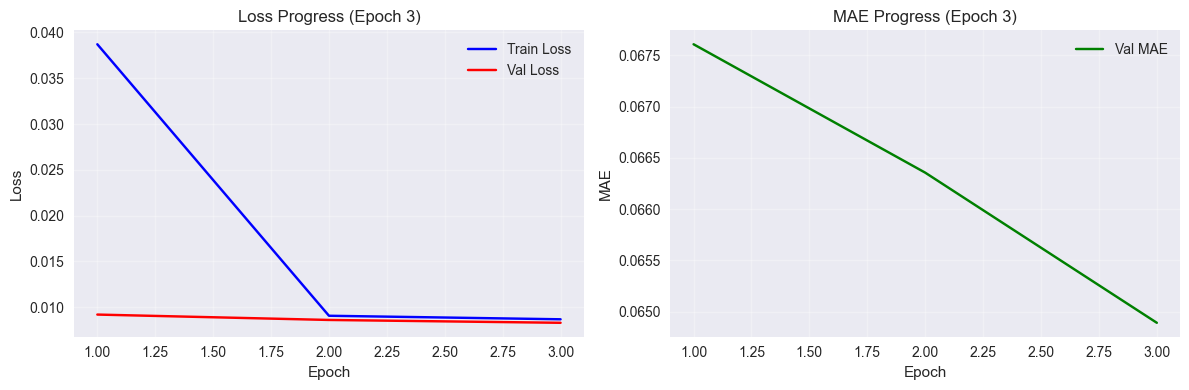

💾 Model saved to: models/best_tcn_model.pth
✅ New best model

Done. Best val loss: 0.0083

🎨 Generating training visualizations...
📊 Creating training overview...


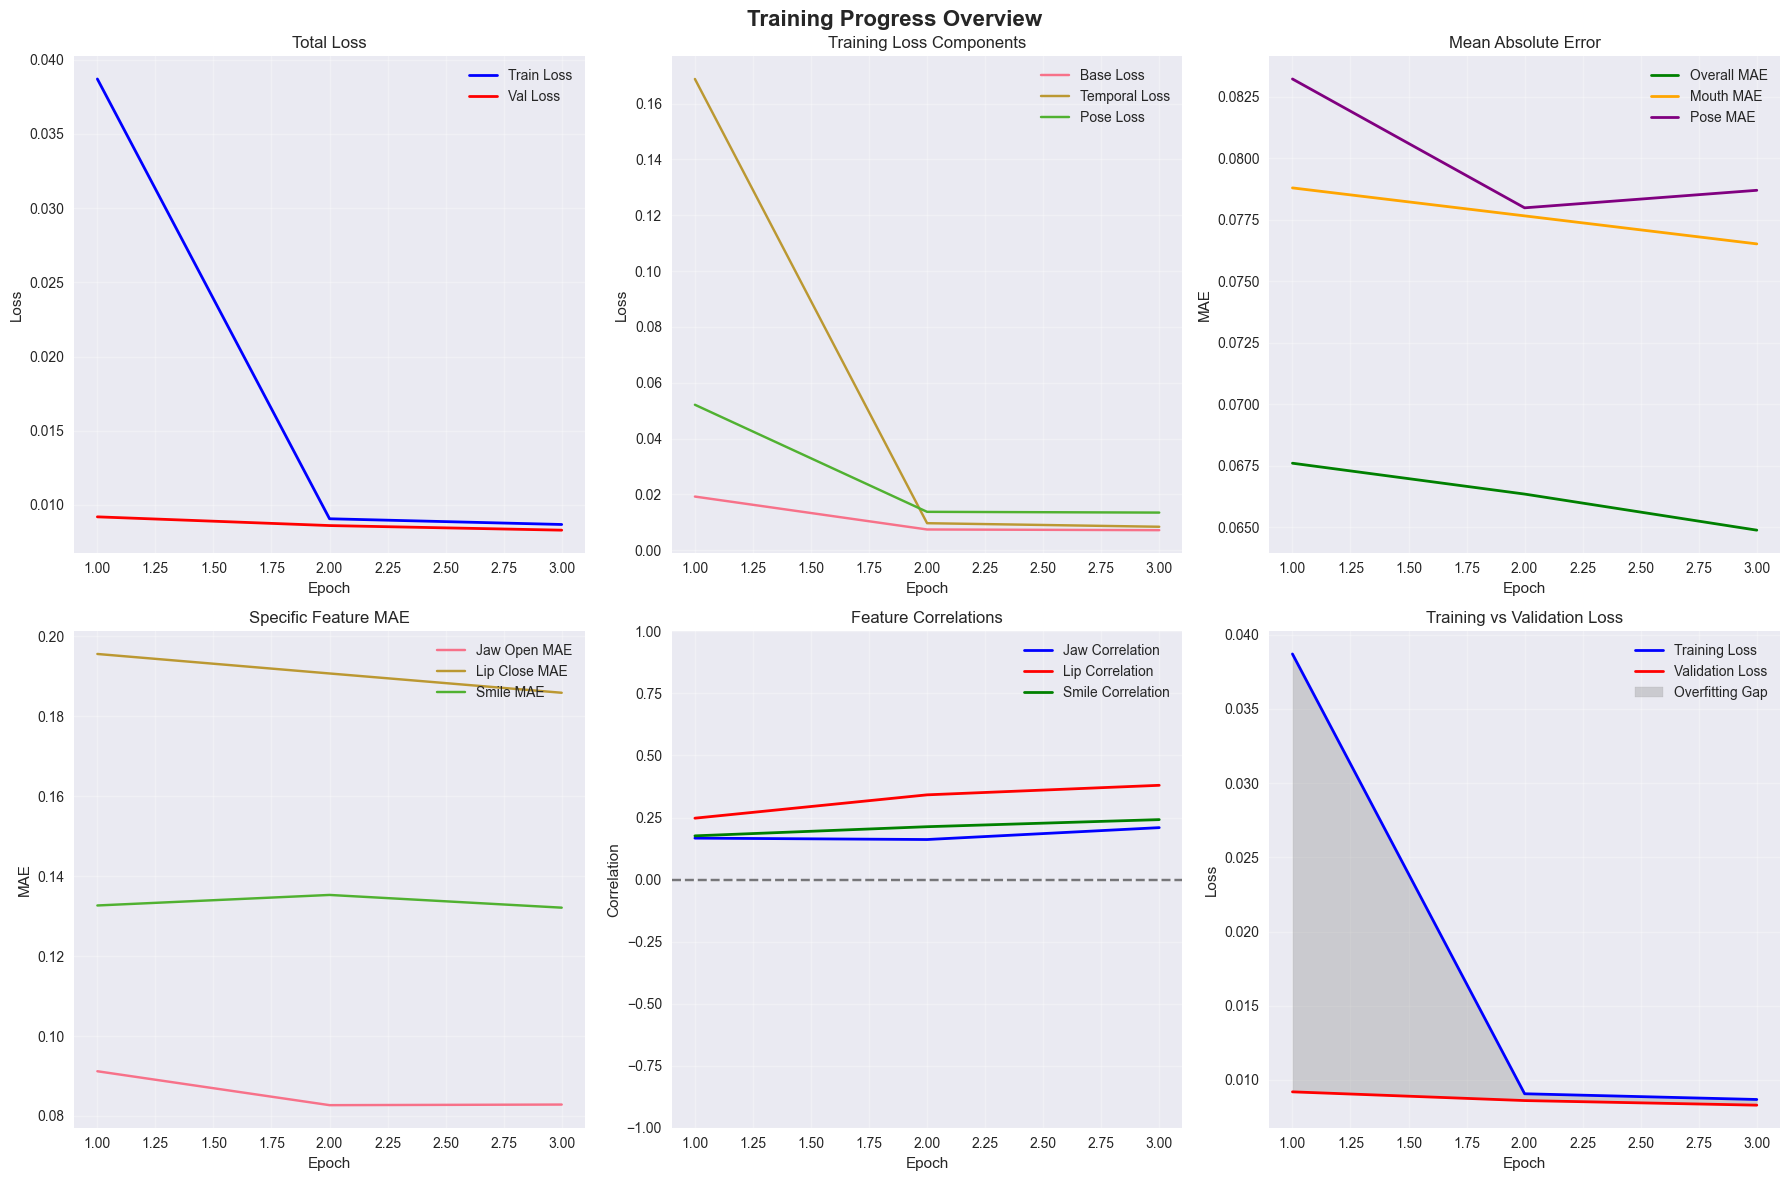

📈 Creating loss breakdown analysis...


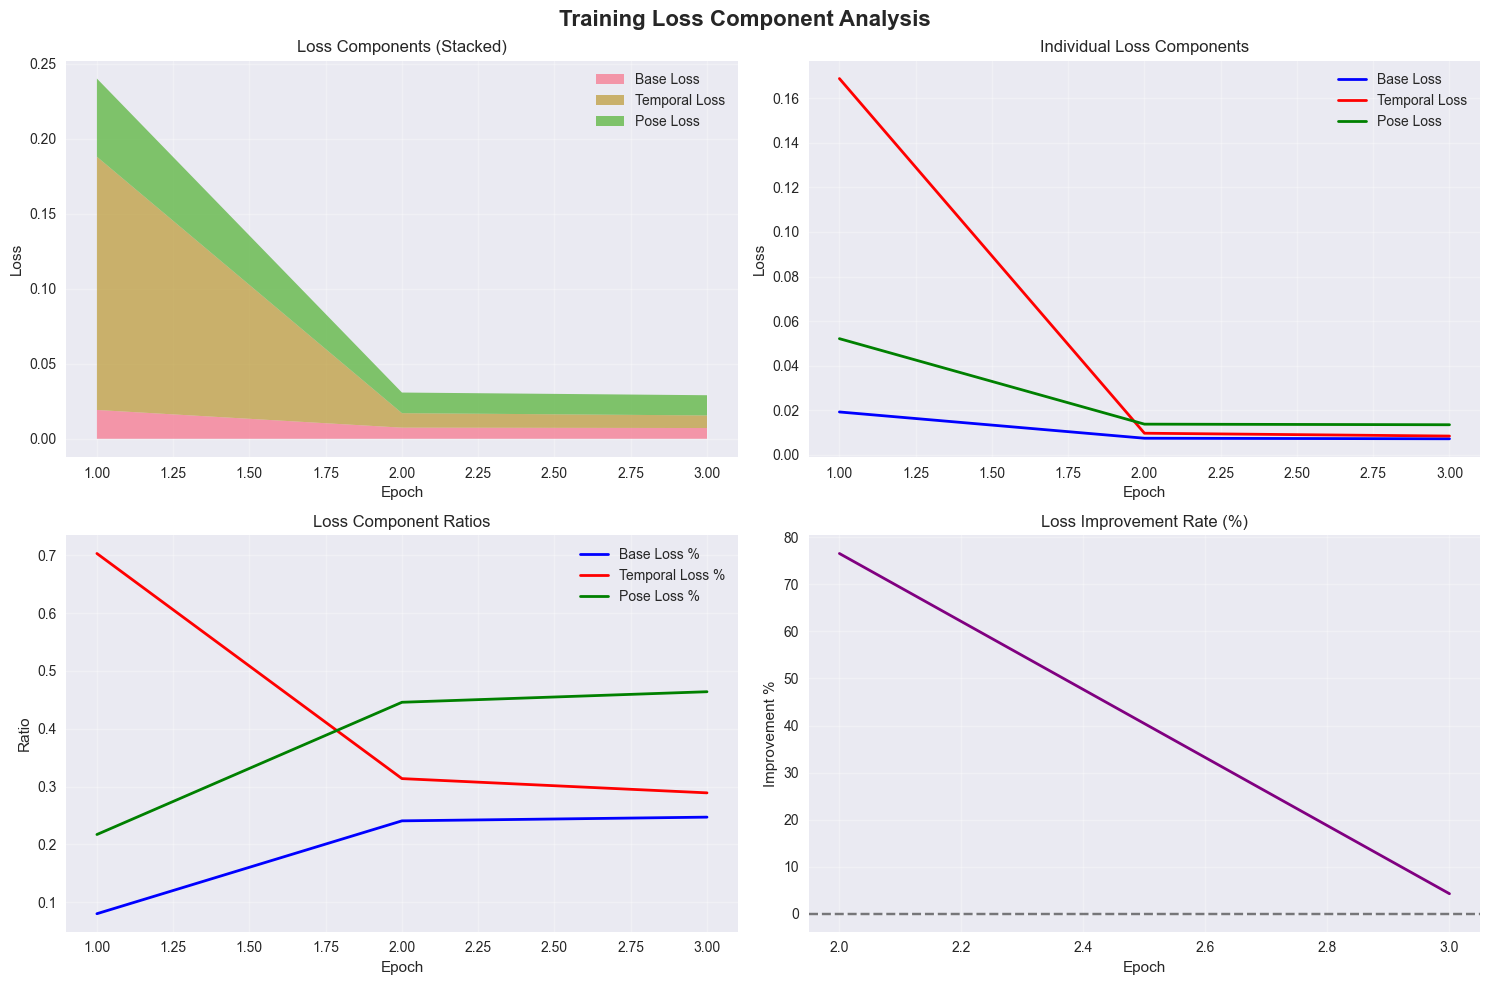

🎭 Creating feature analysis...


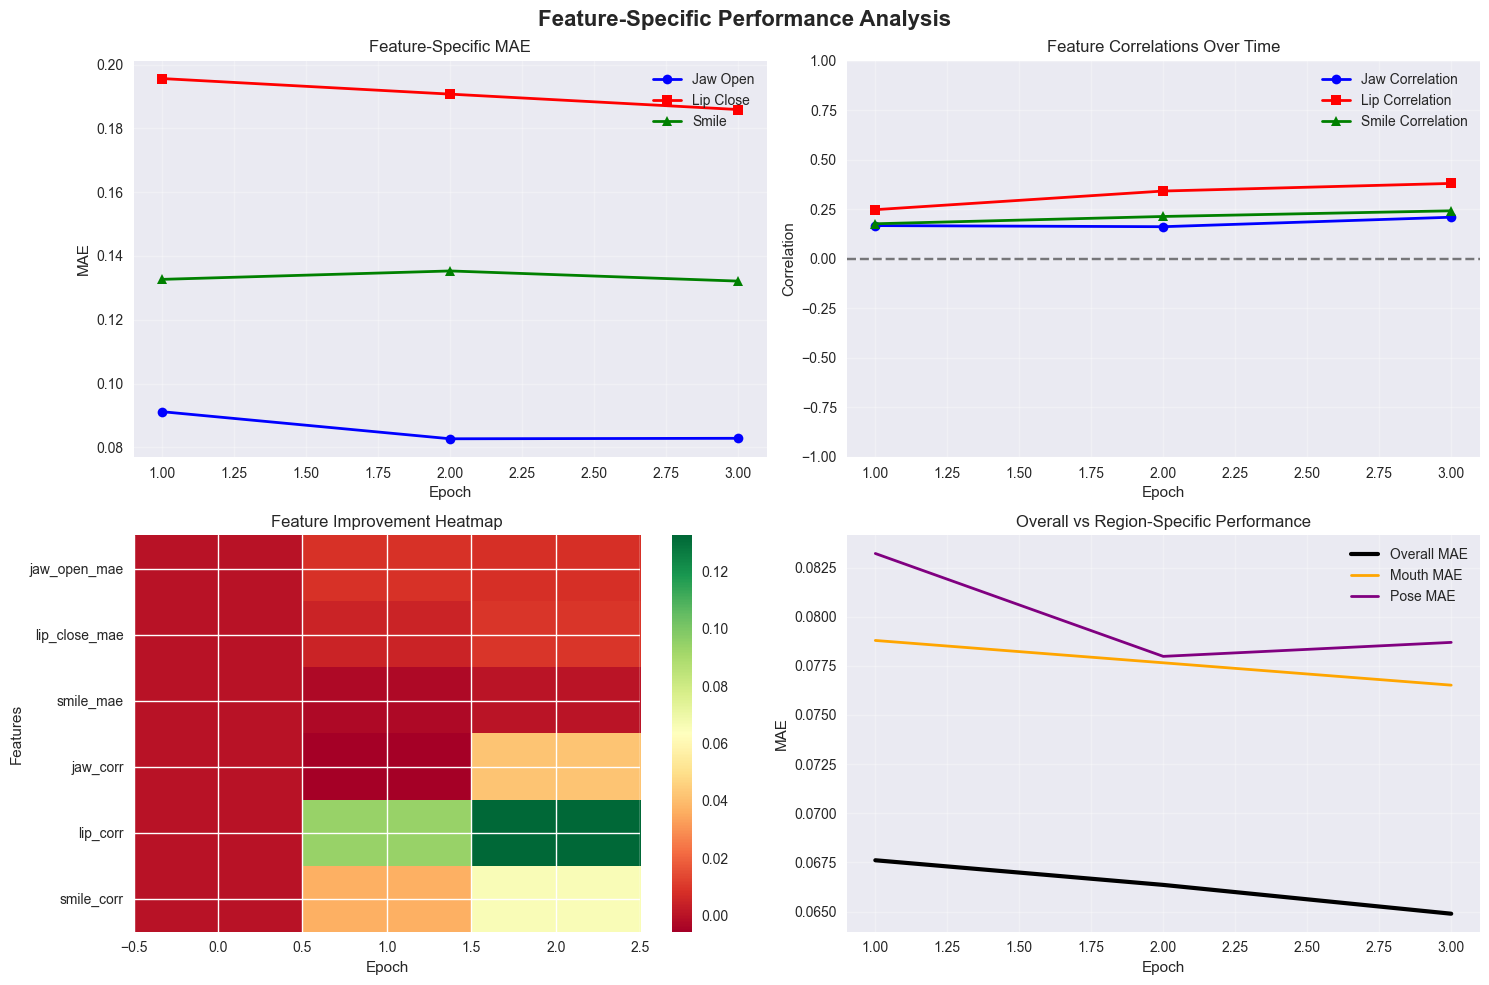

📋 Generating training summary report...
🏋️  TRAINING SUMMARY REPORT
📊 Total Epochs: 3
🎯 Best Validation Loss: 0.008304 (Epoch 3)
📉 Final Training Loss: 0.008686
📈 Final Validation Loss: 0.008304

🎭 FEATURE PERFORMANCE
Overall MAE:     Final: 0.0649 | Best: 0.0649
Mouth MAE:       Final: 0.0765 | Best: 0.0765
Jaw Open MAE:    Final: 0.0828 | Best: 0.0828
Lip Close MAE:   Final: 0.1859 | Best: 0.1859
Smile MAE:       Final: 0.1321 | Best: 0.1321
Pose MAE:        Final: 0.0787 | Best: 0.0787

Jaw Correlation:   Final: 0.209 | Best: 0.209
Lip Correlation:   Final: 0.380 | Best: 0.380
Smile Correlation: Final: 0.242 | Best: 0.242

📈 TRAINING STABILITY
Loss Standard Deviation: 0.000456
Loss Trend (slope): -0.00044876 📉 Improving
Train-Val Gap: 0.000383 ✅ Good Generalization
✅ All plots saved to: plots

Training completed successfully!


In [11]:
# step 2 training the model 
#!/usr/bin/env python3
"""
Train Audio-to-Blendshapes (TCN) on extracted features.

Defaults to training on the TEST dataset features at:
    data/test/extracted_features

To train on the MAIN dataset instead, change:
    DATA_DIR = Path("data/test/extracted_features")
to:
    DATA_DIR = Path("data/train/extracted_features")
"""

import os
import json
import math
import warnings
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from scipy.stats import pearsonr

warnings.filterwarnings("ignore")


# -----------------------------
# Simple TCN model (dilated temporal convs)
# -----------------------------
class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, dilation=1, dropout=0.1):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2  # keep length
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, padding=padding, dilation=dilation)
        self.norm1 = nn.BatchNorm1d(out_ch)
        self.act1 = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=padding, dilation=dilation)
        self.norm2 = nn.BatchNorm1d(out_ch)
        self.act2 = nn.GELU()
        self.dropout2 = nn.Dropout(dropout)

        self.res = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x):
        y = self.conv1(x)
        y = self.norm1(y)
        y = self.act1(y)
        y = self.dropout1(y)

        y = self.conv2(y)
        y = self.norm2(y)
        y = self.act2(y)
        y = self.dropout2(y)

        return y + self.res(x)


class TCNModel(nn.Module):
    def __init__(self, in_features: int, out_features: int = 59,
                 hidden: int = 128, levels: int = 4, kernel_size: int = 3, dropout: float = 0.1):
        super().__init__()
        chans = [in_features] + [hidden] * levels
        blocks = []
        for i in range(levels):
            dilation = 2 ** i
            blocks.append(
                TemporalBlock(chans[i], chans[i + 1], kernel_size=kernel_size, dilation=dilation, dropout=dropout)
            )
        self.tcn = nn.Sequential(*blocks)
        self.head = nn.Conv1d(hidden, out_features, kernel_size=1)

        # store config for saving
        self._config = dict(in_features=in_features, out_features=out_features,
                            hidden=hidden, levels=levels, kernel_size=kernel_size, dropout=dropout)

    def forward(self, x):
        """
        x: (B, T, F_in)  ->  y: (B, T, 59)
        """
        x = x.permute(0, 2, 1)         # (B, F_in, T)
        y = self.tcn(x)                # (B, hidden, T)
        y = self.head(y)               # (B, 59, T)
        y = y.permute(0, 2, 1)         # (B, T, 59)
        return y

    def get_model_info(self):
        return self._config


def create_model(in_features: int, out_features: int = 59) -> nn.Module:
    """Factory expected by your trainer."""
    return TCNModel(in_features=in_features, out_features=out_features)


# -----------------------------
# Loss (your original, unchanged except prints trimmed)
# -----------------------------
class AudioBlendshapeLoss(nn.Module):
    def __init__(self, base_weight=1.0, temporal_weight=0.0, silence_weight=0.0, pose_clamp_weight=0.0):
        super().__init__()
        self.base_weight = base_weight
        self.temporal_weight = temporal_weight
        self.silence_weight = silence_weight
        self.pose_clamp_weight = pose_clamp_weight
        self.mouth_indices = [10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
        self.pose_indices = list(range(52, 59))

    def enable_temporal_loss(self, weight=0.1):
        self.temporal_weight = weight

    def enable_silence_loss(self, weight=2.0):
        self.silence_weight = weight

    def enable_pose_loss(self, weight=0.05):
        self.pose_clamp_weight = weight

    def forward(self, predictions, targets, voice_activity=None):
        base_loss = nn.functional.smooth_l1_loss(predictions, targets, reduction='mean')

        # temporal
        pred_diff1 = predictions[:, 1:] - predictions[:, :-1]
        target_diff1 = targets[:, 1:] - targets[:, :-1]
        temporal_loss1 = torch.mean(torch.abs(pred_diff1 - target_diff1))
        pred_diff2 = pred_diff1[:, 1:] - pred_diff1[:, :-1]
        target_diff2 = target_diff1[:, 1:] - target_diff1[:, :-1]
        temporal_loss2 = torch.mean(torch.abs(pred_diff2 - target_diff2))
        temporal_loss = temporal_loss1 + temporal_loss2

        # silence
        silence_loss = 0.0
        if voice_activity is not None and self.silence_weight > 0:
            silence_mask = (voice_activity.unsqueeze(-1) == 0)
            if silence_mask.any():
                mouth_pred = predictions[:, :, self.mouth_indices]
                mouth_target = targets[:, :, self.mouth_indices]
                mouth_error = torch.abs(mouth_pred - mouth_target)
                silence_error = mouth_error[silence_mask.expand_as(mouth_error)]
                silence_loss = silence_error.mean() if silence_error.numel() > 0 else 0.0

        # pose clamp
        pose_loss = 0.0
        if self.pose_clamp_weight > 0:
            pose_pred = predictions[:, :, self.pose_indices]
            pose_target = targets[:, :, self.pose_indices]
            trans_pred = pose_pred[:, :, :3]
            trans_clamped = torch.clamp(trans_pred, -0.2, 0.2)
            clamp_penalty = torch.mean((trans_pred - trans_clamped) ** 2)
            pose_loss = nn.functional.mse_loss(pose_pred, pose_target, reduction='mean') + clamp_penalty

        total_loss = (
            self.base_weight * base_loss +
            self.temporal_weight * temporal_loss +
            self.silence_weight * (silence_loss if not isinstance(silence_loss, float) else torch.tensor(silence_loss, device=predictions.device)) +
            self.pose_clamp_weight * (pose_loss if not isinstance(pose_loss, float) else torch.tensor(pose_loss, device=predictions.device))
        )

        return {
            'total_loss': total_loss,
            'base_loss': base_loss.item(),
            'temporal_loss': temporal_loss.item(),
            'silence_loss': silence_loss if isinstance(silence_loss, float) else silence_loss.item(),
            'pose_loss': pose_loss if isinstance(pose_loss, float) else pose_loss.item()
        }


# -----------------------------
# Trainer (cleaned & made robust)
# -----------------------------
class TCNTrainer:
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu', enable_visualization=True):
        self.model = model.to(device)
        self.device = device
        self.criterion = AudioBlendshapeLoss()
        self.jaw_open_idx = 25
        self.lip_close_idx = 12
        self.smile_idx = 20
        
        # Initialize visualizer
        self.enable_visualization = enable_visualization
        if self.enable_visualization:
            self.visualizer = TrainingVisualizer()
            print("📊 Visualization enabled - plots will be generated during training")

    def setup_optimizer(self, learning_rate=2e-3, weight_decay=1e-4):
        self.optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.base_lr = learning_rate
        self.max_lr = 3e-3

    def setup_scheduler(self, total_steps):
        if total_steps <= 0:
            self.scheduler = None
            return
        self.scheduler = optim.lr_scheduler.OneCycleLR(
            self.optimizer, max_lr=self.max_lr, total_steps=total_steps, pct_start=0.3, anneal_strategy='cos'
        )

    def load_dataset(self, data_dir: Path, normalize=True):
        audio = np.load(data_dir / "audio_sequences.npy")
        targets = np.load(data_dir / "target_sequences.npy")
        vad = np.load(data_dir / "vad_sequences.npy")
        with open(data_dir / "dataset_metadata.json", "r") as f:
            metadata = json.load(f)

        print(f"Dataset: {data_dir}")
        print(f"  audio   : {audio.shape}  (B, T, F_audio)")
        print(f"  targets : {targets.shape} (B, T, 59)")
        print(f"  vad     : {vad.shape}     (B, T)")

        if normalize:
            m = audio.mean(axis=(0, 1), keepdims=True)
            s = audio.std(axis=(0, 1), keepdims=True) + 1e-6
            audio = (audio - m) / s
            print(f"  audio z-norm -> mean≈{float(m.mean()):.4f}, std≈{float(s.mean()):.4f}")

            blend = targets[:, :, :52]
            pose = targets[:, :, 52:]
            if blend.min() < -0.1 or blend.max() > 1.1:
                print("  WARNING: blendshape range outside [0,1]")
            if np.abs(pose).max() > 0.5:
                print(f"  WARNING: pose large values (max abs {np.abs(pose).max():.3f})")

        return {
            'audio': torch.from_numpy(audio).float(),
            'targets': torch.from_numpy(targets).float(),
            'vad': torch.from_numpy(vad).float(),
            'metadata': metadata
        }

    def create_data_loader(self, dataset, batch_size=16, shuffle=True):
        ds = torch.utils.data.TensorDataset(dataset['audio'], dataset['targets'], dataset['vad'])
        return torch.utils.data.DataLoader(
            ds, batch_size=batch_size, shuffle=shuffle,
            num_workers=0, pin_memory=(self.device == 'cuda')
        )

    def train_epoch(self, loader):
        self.model.train()
        agg = dict(total_loss=0.0, base_loss=0.0, temporal_loss=0.0, silence_loss=0.0, pose_loss=0.0)
        n = 0

        for audio, targets, vad in tqdm(loader, desc="Training"):
            audio, targets, vad = audio.to(self.device), targets.to(self.device), vad.to(self.device)

            preds = self.model(audio)
            loss_dict = self.criterion(preds, targets, vad)

            self.optimizer.zero_grad()
            loss_dict['total_loss'].backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            if self.scheduler is not None:
                self.scheduler.step()

            for k in agg:
                agg[k] += float(loss_dict[k])
            n += 1

        for k in agg:
            agg[k] /= max(n, 1)
        return agg

    def validate(self, loader):
        self.model.eval()
        agg = dict(total_loss=0.0, base_loss=0.0, temporal_loss=0.0, silence_loss=0.0, pose_loss=0.0)
        n = 0
        preds_all, targs_all = [], []

        with torch.no_grad():
            for audio, targets, vad in tqdm(loader, desc="Validation"):
                audio, targets, vad = audio.to(self.device), targets.to(self.device), vad.to(self.device)
                preds = self.model(audio)
                loss_dict = self.criterion(preds, targets, vad)

                for k in agg:
                    agg[k] += float(loss_dict[k])
                n += 1

                preds_all.append(preds.cpu())
                targs_all.append(targets.cpu())

        for k in agg:
            agg[k] /= max(n, 1)

        preds_all = torch.cat(preds_all, dim=0)
        targs_all = torch.cat(targs_all, dim=0)
        agg.update(self.compute_detailed_metrics(preds_all, targs_all))
        return agg

    def compute_detailed_metrics(self, predictions, targets):
        pred = predictions.view(-1, predictions.size(-1)).numpy()
        targ = targets.view(-1, targets.size(-1)).numpy()

        mae_ch = np.mean(np.abs(pred - targ), axis=0)
        overall_mae = float(np.mean(mae_ch))
        mouth_mae = float(np.mean(mae_ch[10:30]))
        jaw_open_mae = float(mae_ch[self.jaw_open_idx])
        lip_close_mae = float(mae_ch[self.lip_close_idx])
        smile_mae = float(mae_ch[self.smile_idx])
        pose_mae = float(np.mean(mae_ch[52:59]))

        def safe_r(a, b):
            r = pearsonr(a, b)[0]
            return float(0.0 if np.isnan(r) else r)

        jaw_corr = safe_r(pred[:, self.jaw_open_idx], targ[:, self.jaw_open_idx])
        lip_corr = safe_r(pred[:, self.lip_close_idx], targ[:, self.lip_close_idx])
        smile_corr = safe_r(pred[:, self.smile_idx], targ[:, self.smile_idx])

        return dict(
            overall_mae=overall_mae,
            mouth_mae=mouth_mae,
            jaw_open_mae=jaw_open_mae,
            lip_close_mae=lip_close_mae,
            smile_mae=smile_mae,
            pose_mae=pose_mae,
            jaw_corr=jaw_corr,
            lip_corr=lip_corr,
            smile_corr=smile_corr
        )

    def save_model(self, path, metrics=None):
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'model_config': self.model.get_model_info(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'validation_metrics': metrics
        }, path)
        print(f"💾 Model saved to: {path}")

    def train(self, dataset, num_epochs=15, batch_size=16, validation_split=0.2):
        total_samples = len(dataset['audio'])
        val_size = int(total_samples * validation_split)
        train_size = total_samples - val_size

        idx = torch.randperm(total_samples)
        train_idx, val_idx = idx[:train_size], idx[train_size:]

        train_ds = {k: v[train_idx] for k, v in dataset.items() if k in ('audio', 'targets', 'vad')}
        val_ds   = {k: v[val_idx]   for k, v in dataset.items() if k in ('audio', 'targets', 'vad')}

        train_loader = self.create_data_loader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = self.create_data_loader(val_ds, batch_size=batch_size, shuffle=False)

        self.setup_optimizer()
        total_steps = len(train_loader) * num_epochs
        self.setup_scheduler(total_steps)

        print("\n=== Training config ===")
        print(f"Device         : {self.device}")
        print(f"Samples        : total={total_samples}, train={train_size}, val={val_size}")
        print(f"Batch size     : {batch_size}")
        print(f"Total steps    : {total_steps}")

        best_val = math.inf
        history = []

        for epoch in range(1, num_epochs + 1):
            print(f"\nEpoch {epoch}/{num_epochs}")
            tr = self.train_epoch(train_loader)
            va = self.validate(val_loader)

            print(f"Train: loss={tr['total_loss']:.4f} (base={tr['base_loss']:.4f}, temp={tr['temporal_loss']:.4f}, sil={tr['silence_loss']:.4f}, pose={tr['pose_loss']:.4f})")
            print(f" Val : loss={va['total_loss']:.4f} (MAE={va['overall_mae']:.4f}, jaw_r={va['jaw_corr']:.3f}, lip_r={va['lip_corr']:.3f}, mouth_MAE={va['mouth_mae']:.4f})")

            epoch_data = dict(epoch=epoch, train=tr, val=va)
            history.append(epoch_data)
            
            # Add to visualizer
            if self.enable_visualization:
                self.visualizer.add_epoch_data(epoch_data)
                
                # Show real-time plot every 5 epochs or at the end
                if epoch % 5 == 0 or epoch == num_epochs:
                    try:
                        self.visualizer.plot_real_time_training(epoch, tr, va)
                    except Exception as e:
                        print(f"⚠️  Visualization error: {e}")

            if va['total_loss'] < best_val:
                best_val = va['total_loss']
                self.save_model("models/best_tcn_model.pth", va)
                print("✅ New best model")

        print(f"\nDone. Best val loss: {best_val:.4f}")
        
        # Generate comprehensive visualizations at the end
        if self.enable_visualization and len(history) > 1:
            print("\n🎨 Generating training visualizations...")
            try:
                # Save training history
                self.visualizer.save_history("training_history.json")
                
                # Generate comprehensive plots
                print("📊 Creating training overview...")
                self.visualizer.plot_training_overview(save=True)
                
                print("📈 Creating loss breakdown analysis...")
                self.visualizer.plot_loss_breakdown(save=True)
                
                print("🎭 Creating feature analysis...")
                self.visualizer.plot_feature_analysis(save=True)
                
                print("📋 Generating training summary report...")
                self.visualizer.create_training_summary_report()
                
                print(f"✅ All plots saved to: {self.visualizer.save_dir}")
                
            except Exception as e:
                print(f"⚠️  Error generating final visualizations: {e}")
        
        return history


# -----------------------------
# Main
# -----------------------------
def main():
    # —— CHANGE THIS LINE to switch datasets ——
    DATA_DIR = Path("data/train/")   # <-- for MAIN: Path("data/train/")

    # Load data first so we know input feature size
    tmp_device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dummy_trainer = TCNTrainer(model=nn.Identity(), device=tmp_device)  # temp to use loader
    dataset = dummy_trainer.load_dataset(DATA_DIR)

    in_features = dataset['audio'].shape[-1]
    model = create_model(in_features=in_features, out_features=59)

    trainer = TCNTrainer(model)
    trainer.criterion.enable_temporal_loss(0.1)  # optional: staged losses
    trainer.criterion.enable_pose_loss(0.05)
    # uncomment to emphasize silence mouth stability if your VAD is reliable:
    # trainer.criterion.enable_silence_loss(2.0)

    history = trainer.train(dataset, num_epochs=3, batch_size=16, validation_split=0.2)
    print("\nTraining completed successfully!")

if __name__ == "__main__":
    main()


📚 Loaded training history with 3 epochs

🎨 Generating comprehensive analysis...


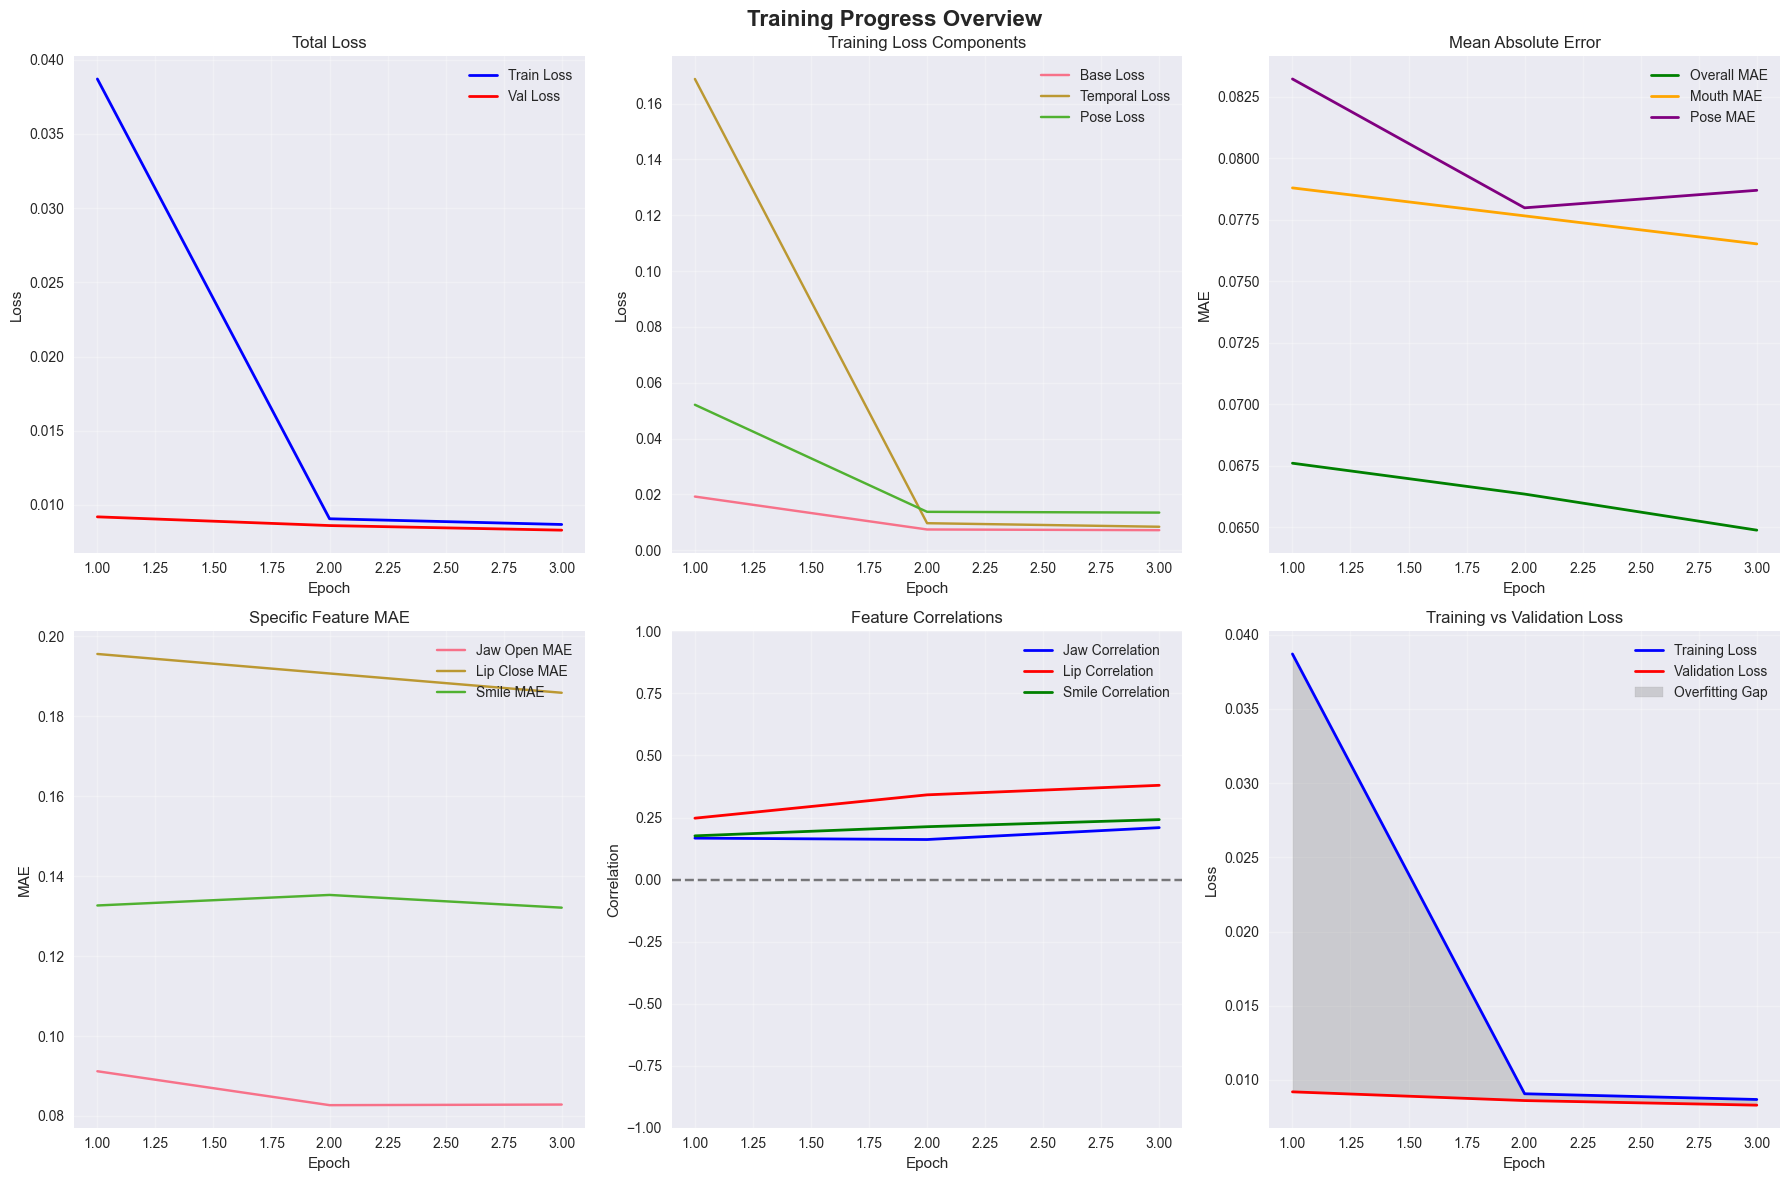

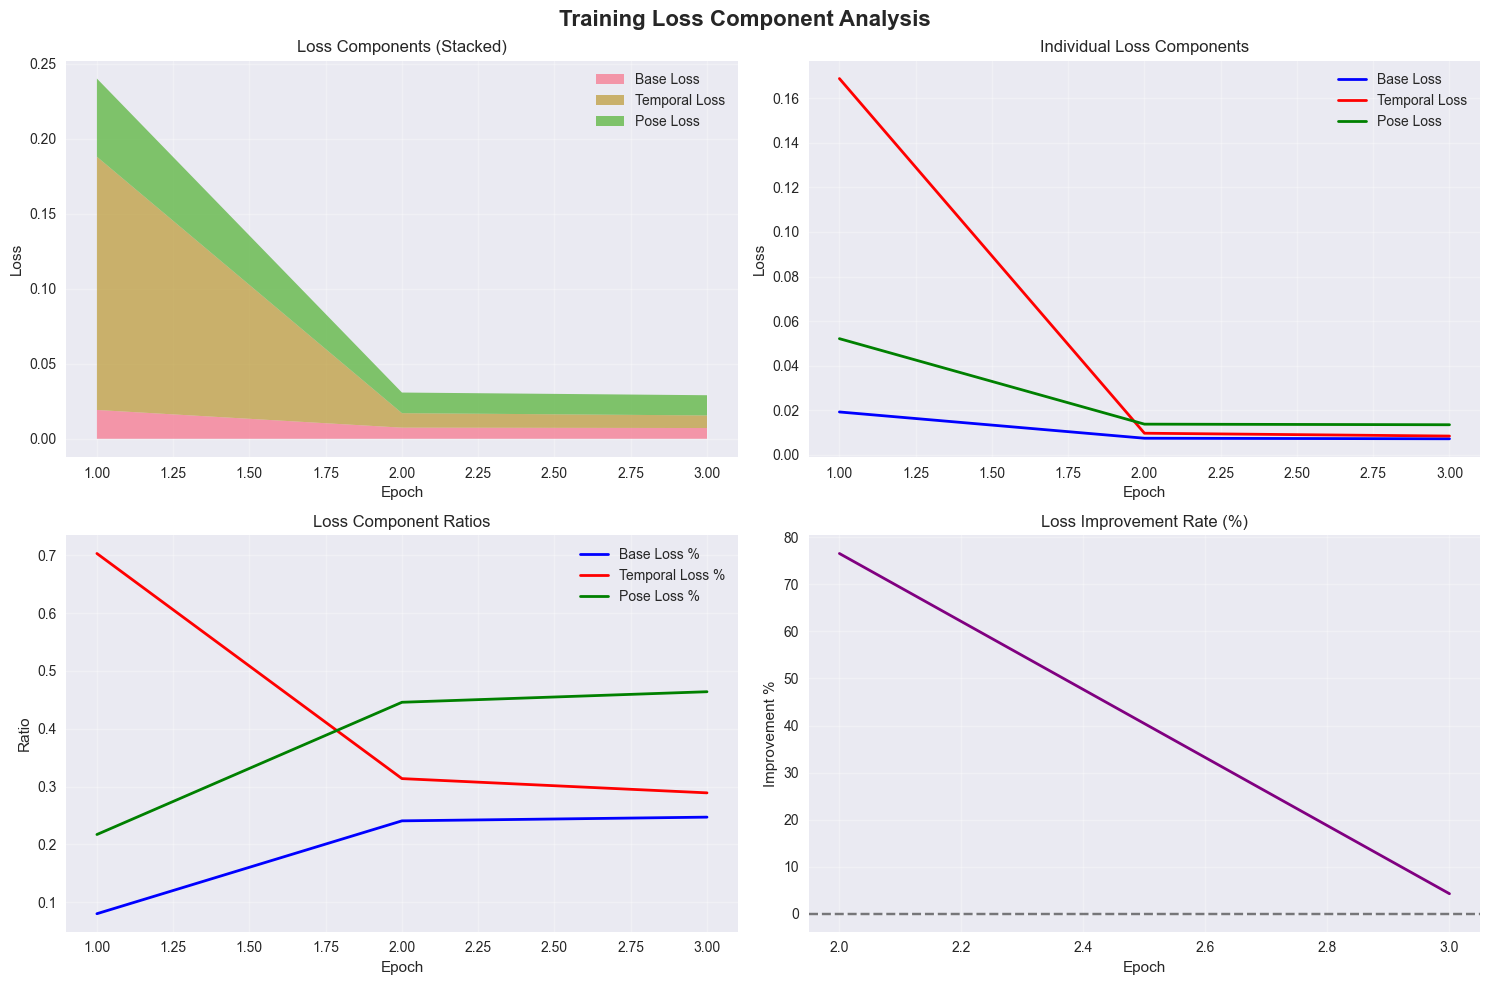

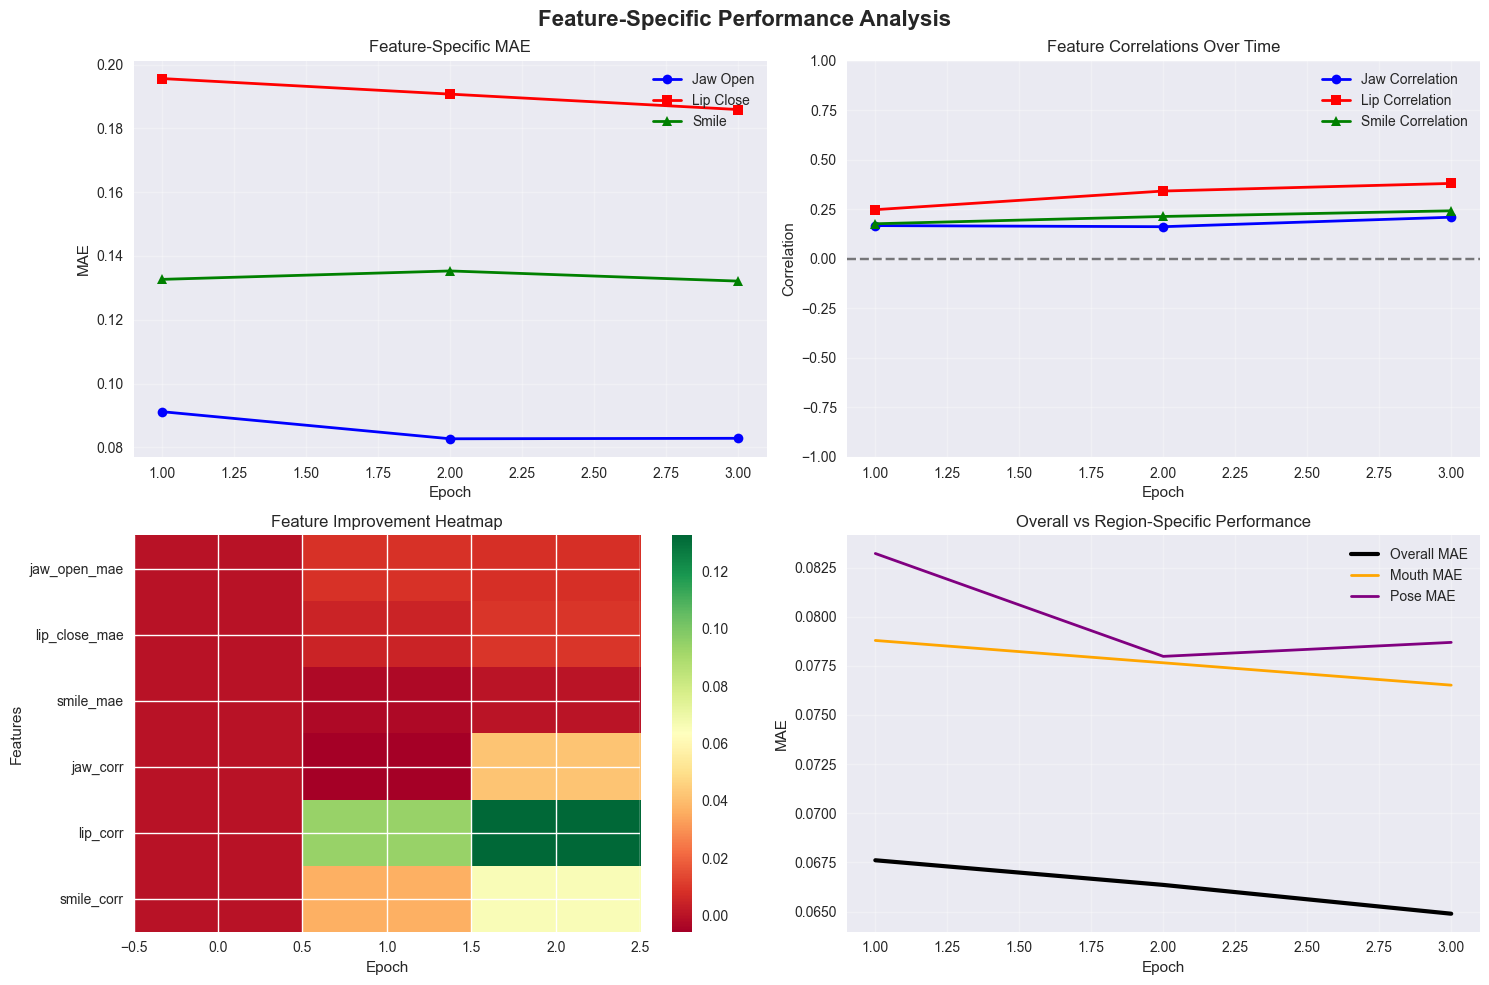

🏋️  TRAINING SUMMARY REPORT
📊 Total Epochs: 3
🎯 Best Validation Loss: 0.008304 (Epoch 3)
📉 Final Training Loss: 0.008686
📈 Final Validation Loss: 0.008304

🎭 FEATURE PERFORMANCE
Overall MAE:     Final: 0.0649 | Best: 0.0649
Mouth MAE:       Final: 0.0765 | Best: 0.0765
Jaw Open MAE:    Final: 0.0828 | Best: 0.0828
Lip Close MAE:   Final: 0.1859 | Best: 0.1859
Smile MAE:       Final: 0.1321 | Best: 0.1321
Pose MAE:        Final: 0.0787 | Best: 0.0787

Jaw Correlation:   Final: 0.209 | Best: 0.209
Lip Correlation:   Final: 0.380 | Best: 0.380
Smile Correlation: Final: 0.242 | Best: 0.242

📈 TRAINING STABILITY
Loss Standard Deviation: 0.000456
Loss Trend (slope): -0.00044876 📉 Improving
Train-Val Gap: 0.000383 ✅ Good Generalization

✅ Analysis complete! Check the 'plots' folder for saved plots.


In [12]:
# Post-Training Analysis and Visualization
# Use this cell to analyze and visualize training results after training is complete

# Initialize visualizer for post-training analysis
post_visualizer = TrainingVisualizer()

# Try to load existing training history
try:
    post_visualizer.load_history("training_history.json")
    print(f"📚 Loaded training history with {len(post_visualizer.history)} epochs")
    
    if len(post_visualizer.history) > 0:
        print("\n🎨 Generating comprehensive analysis...")
        
        # Generate all visualizations
        post_visualizer.plot_training_overview(save=True)
        post_visualizer.plot_loss_breakdown(save=True) 
        post_visualizer.plot_feature_analysis(save=True)
        post_visualizer.create_training_summary_report()
        
        print(f"\n✅ Analysis complete! Check the '{post_visualizer.save_dir}' folder for saved plots.")
    else:
        print("❌ No training history found. Run training first!")
        
except Exception as e:
    print(f"❌ Could not load training history: {e}")
    print("💡 Make sure you've run training with visualization enabled first!")
    
    # Alternative: Create sample analysis from the console output
    print("\n💡 Alternative: If you have training output, you can manually create history...")
    print("Example usage:")
    print("visualizer = TrainingVisualizer()")
    print("# Add epoch data manually:")
    print("visualizer.add_epoch_data({'epoch': 1, 'train': {...}, 'val': {...}})")
    print("# Then generate plots:")


### Step 2.5 trainign the 10s model 
Here we train with actual audio blend shapes 10-second model below this cell.

### Step 3 Do inference 

📚 Simple Audio-to-Blendshapes Inference Usage:

Basic usage:
```
inference = SimpleAudioInference("models/best_tcn_model.pth")
results = inference.infer("path/to/audio.wav")
```

With options:
```
results = inference.infer(
    "path/to/audio.mp3",
    max_duration=30,      # Process first 30 seconds
    target_fps=30,        # Output at 30fps
    save_json="output.json"  # Save results
)
```

Visualize results:
```
inference.visualize_results(results)
inference.get_sample_values(results)
```

Quick one-liner:
```
results = quick_infer("audio.wav")
```





In [29]:
import torch
import torch.nn as nn
import numpy as np
import json
import librosa
import os
from pathlib import Path
import warnings
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

# Model architecture (inline)
class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, dilation=1, dropout=0.1):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, padding=padding, dilation=dilation)
        self.norm1 = nn.BatchNorm1d(out_ch)
        self.act1 = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=padding, dilation=dilation)
        self.norm2 = nn.BatchNorm1d(out_ch)
        self.act2 = nn.GELU()
        self.dropout2 = nn.Dropout(dropout)
        self.res = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x):
        y = self.conv1(x)
        y = self.norm1(y)
        y = self.act1(y)
        y = self.dropout1(y)
        y = self.conv2(y)
        y = self.norm2(y)
        y = self.act2(y)
        y = self.dropout2(y)
        return y + self.res(x)

class TCNModel(nn.Module):
    def __init__(self, in_features: int, out_features: int = 59,
                 hidden: int = 128, levels: int = 4, kernel_size: int = 3, dropout: float = 0.1):
        super().__init__()
        chans = [in_features] + [hidden] * levels
        blocks = []
        for i in range(levels):
            dilation = 2 ** i
            blocks.append(TemporalBlock(chans[i], chans[i + 1], kernel_size=kernel_size, dilation=dilation, dropout=dropout))
        self.tcn = nn.Sequential(*blocks)
        self.head = nn.Conv1d(hidden, out_features, kernel_size=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        y = self.tcn(x)
        y = self.head(y)
        y = y.permute(0, 2, 1)
        return y

# Simple inference class
class AudioInference:
    def __init__(self, model_path, device='auto'):
        if device == 'auto':
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.device = device
        self.model_path = model_path
        self.sample_rate = 16000
        self.n_mels = 80
        self.hop_length = 160
        self.win_length = 400
        self.n_fft = 512
        
        self.model = self._load_model()
        
        self.blendshape_names = [
            '_neutral', 'browDownLeft', 'browDownRight', 'browInnerUp', 'browOuterUpLeft', 
            'browOuterUpRight', 'cheekPuff', 'cheekSquintLeft', 'cheekSquintRight', 'eyeBlinkLeft', 
            'eyeBlinkRight', 'eyeLookDownLeft', 'eyeLookDownRight', 'eyeLookInLeft', 'eyeLookInRight', 
            'eyeLookOutLeft', 'eyeLookOutRight', 'eyeLookUpLeft', 'eyeLookUpRight', 'eyeSquintLeft', 
            'eyeSquintRight', 'eyeWideLeft', 'eyeWideRight', 'jawForward', 'jawLeft', 'jawOpen', 
            'jawRight', 'mouthClose', 'mouthDimpleLeft', 'mouthDimpleRight', 'mouthFrownLeft', 
            'mouthFrownRight', 'mouthFunnel', 'mouthLeft', 'mouthLowerDownLeft', 'mouthLowerDownRight', 
            'mouthPressLeft', 'mouthPressRight', 'mouthPucker', 'mouthRight', 'mouthRollLower', 
            'mouthRollUpper', 'mouthShrugLower', 'mouthShrugUpper', 'mouthSmileLeft', 'mouthSmileRight', 
            'mouthStretchLeft', 'mouthStretchRight', 'mouthUpperUpLeft', 'mouthUpperUpRight', 
            'noseSneerLeft', 'noseSneerRight'
        ]
        
    def _load_model(self):
        checkpoint = torch.load(self.model_path, map_location=self.device)
        
        if 'model_config' in checkpoint:
            in_features = checkpoint['model_config'].get('in_features', 80)
        else:
            in_features = 80
            
        model = TCNModel(in_features=in_features, out_features=59)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(self.device)
        model.eval()
        return model
    
    def infer(self, audio_path, max_duration=None, target_fps=30, save_json=None):
        # Load audio
        audio, sr = librosa.load(audio_path, sr=self.sample_rate, mono=True, duration=max_duration)
        
        # Extract mel features
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=self.sample_rate, n_mels=self.n_mels,
            hop_length=self.hop_length, win_length=self.win_length, n_fft=self.n_fft
        )
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        mel_features = log_mel.T
        
        # Normalize
        mel_mean = mel_features.mean(axis=0, keepdims=True)
        mel_std = mel_features.std(axis=0, keepdims=True) + 1e-6
        mel_features = (mel_features - mel_mean) / mel_std
        
        # Run inference
        mel_tensor = torch.FloatTensor(mel_features).to(self.device)
        batch_size = 32
        all_predictions = []
        
        with torch.no_grad():
            for i in range(0, len(mel_tensor), batch_size):
                end_idx = min(i + batch_size, len(mel_tensor))
                batch_mel = mel_tensor[i:end_idx].unsqueeze(0)
                batch_pred = self.model(batch_mel)
                all_predictions.append(batch_pred.squeeze(0).cpu().numpy())
        
        predictions = np.concatenate(all_predictions, axis=0)
        
        # Downsample to target fps
        original_fps = self.sample_rate / self.hop_length
        if target_fps < original_fps:
            downsample_ratio = original_fps / target_fps
            num_output_frames = int(len(predictions) / downsample_ratio)
            indices = np.linspace(0, len(predictions) - 1, num_output_frames, dtype=int)
            predictions = predictions[indices]
        
        # Process results
        blendshapes = predictions[:, :52]
        head_pose = predictions[:, 52:]
        frame_duration = 1.0 / target_fps
        timestamps = np.arange(len(predictions)) * frame_duration
        
        results = {
            'num_frames': len(predictions),
            'fps': target_fps,
            'duration': timestamps[-1] if len(timestamps) > 0 else 0,
            'timestamps': timestamps,
            'blendshapes': blendshapes,
            'head_pose': head_pose,
            'audio_path': audio_path
        }
        
        # Save JSON if requested
        if save_json:
            frames = []
            for i in range(results['num_frames']):
                blendshapes_dict = {}
                for j, name in enumerate(self.blendshape_names):
                    blendshapes_dict[name] = float(results['blendshapes'][i][j])
                
                frame_data = {
                    'frame_index': i,
                    'timestamp': int(results['timestamps'][i] * 1000),
                    'blendshapes': blendshapes_dict,
                    'headPosition': {
                        'x': float(results['head_pose'][i][0]),
                        'y': float(results['head_pose'][i][1]),
                        'z': float(results['head_pose'][i][2])
                    },
                    'headRotation': {
                        'w': float(results['head_pose'][i][3]),
                        'x': float(results['head_pose'][i][4]),
                        'y': float(results['head_pose'][i][5]),
                        'z': float(results['head_pose'][i][6])
                    },
                    'has_face': True
                }
                frames.append(frame_data)
            
            json_output = {
                'sessionInfo': {
                    'sessionId': f"inference_{hash(results['audio_path']) % 10000}",
                    'targetFPS': results['fps'],
                    'audioPath': results['audio_path']
                },
                'frameCount': results['num_frames'],
                'failedFrames': 0,
                'failureRate': 0.0,
                'frames': frames
            }
            
            Path(save_json).parent.mkdir(parents=True, exist_ok=True)
            with open(save_json, 'w') as f:
                json.dump(json_output, f, indent=2)
        
        return results

# Example usage
audio_file = "sample_audio/sample2.wav"
model_file = "models/best_tcn_model_train_50.pth"

inference = AudioInference(model_file)
results = inference.infer(
    audio_path=audio_file,
    # max_duration=10,
    target_fps=30,
    save_json="output/inference_results.json"
)

### Step 4 ONNX conversion 


In [ ]:
# install dependecies for step 4 first
# uncomment below if not installed and then run the cell
# !pip install --quiet onnx onnxruntime


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
# step 4 convert to ONNX format
# please take the model from best_tcn_model.pth file and convert it to onnx format
# use the architecture and do it proprely please

#!/usr/bin/env python3
"""
Step 4: Convert trained TCN model (.pth) to ONNX format
Converts the best_tcn_model.pth to optimized ONNX runtime format
"""

import torch
import torch.onnx
import onnx
import onnxruntime as ort
import numpy as np
from pathlib import Path
import json
import warnings

# Suppress ONNX warnings
warnings.filterwarnings("ignore", category=UserWarning)

def load_trained_model(model_path="models/best_tcn_model.pth"):
    """
    Load the trained TCN model from .pth file
    """
    print(f"🔄 Loading trained model from: {model_path}")
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location='cpu')
    model_config = checkpoint['model_config']
    
    print(f"📋 Model configuration:")
    for key, value in model_config.items():
        print(f"   {key}: {value}")
    
    # Recreate model with saved config
    model = TCNModel(**model_config)
    
    # Load trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"✅ Model loaded successfully!")
    print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    return model, model_config

def convert_to_onnx(model, model_config, onnx_path="models/tcn_model.onnx"):
    """
    Convert PyTorch TCN model to ONNX format
    """
    print(f"\n🔄 Converting to ONNX format...")
    
    # Set model to evaluation mode
    model.eval()
    
    # Create dummy input based on model config
    batch_size = 1
    sequence_length = 100  # Reasonable sequence length for inference
    input_features = model_config['in_features']
    
    # Create dummy input tensor (batch, time, features)
    dummy_input = torch.randn(batch_size, sequence_length, input_features)
    
    print(f"📊 Input shape: {dummy_input.shape}")
    print(f"   Batch size: {batch_size}")
    print(f"   Sequence length: {sequence_length}")
    print(f"   Input features: {input_features}")
    
    # Create output directory
    Path(onnx_path).parent.mkdir(parents=True, exist_ok=True)
    
    # Export to ONNX
    with torch.no_grad():
        torch.onnx.export(
            model,                          # PyTorch model
            dummy_input,                    # Model input
            onnx_path,                      # Output path
            export_params=True,             # Store trained parameters
            opset_version=11,               # ONNX version
            do_constant_folding=True,       # Optimize constant folding
            input_names=['audio_features'], # Input tensor name
            output_names=['blendshapes'],   # Output tensor name
            dynamic_axes={                  # Dynamic dimensions
                'audio_features': {
                    0: 'batch_size',
                    1: 'sequence_length'
                },
                'blendshapes': {
                    0: 'batch_size', 
                    1: 'sequence_length'
                }
            },
            verbose=False
        )
    
    print(f"✅ ONNX model exported to: {onnx_path}")
    return onnx_path

def verify_onnx_model(onnx_path, model_config):
    """
    Verify ONNX model validity and test inference
    """
    print(f"\n🔍 Verifying ONNX model...")
    
    # Load and check ONNX model
    try:
        onnx_model = onnx.load(onnx_path)
        onnx.checker.check_model(onnx_model)
        print("✅ ONNX model structure is valid")
    except Exception as e:
        print(f"❌ ONNX model validation failed: {e}")
        return False
    
    # Test ONNX Runtime inference
    try:
        # Create ONNX Runtime session
        ort_session = ort.InferenceSession(onnx_path)
        
        # Get input/output info
        input_info = ort_session.get_inputs()[0]
        output_info = ort_session.get_outputs()[0]
        
        print(f"📊 ONNX Runtime Info:")
        print(f"   Input name: {input_info.name}")
        print(f"   Input shape: {input_info.shape}")
        print(f"   Output name: {output_info.name}")
        print(f"   Output shape: {output_info.shape}")
        
        # Test inference with dummy data
        test_input = np.random.randn(1, 50, model_config['in_features']).astype(np.float32)
        
        ort_outputs = ort_session.run(None, {input_info.name: test_input})
        output_shape = ort_outputs[0].shape
        
        print(f"✅ ONNX Runtime inference successful!")
        print(f"   Test input shape: {test_input.shape}")
        print(f"   Test output shape: {output_shape}")
        print(f"   Expected output features: {model_config['out_features']}")
        
        # Verify output dimensions
        if output_shape[-1] == model_config['out_features']:
            print("✅ Output dimensions match expected (59: 52 blendshapes + 7 pose)")
        else:
            print(f"⚠️  Output dimension mismatch: got {output_shape[-1]}, expected {model_config['out_features']}")
        
        return True
        
    except Exception as e:
        print(f"❌ ONNX Runtime test failed: {e}")
        return False

def compare_pytorch_vs_onnx(pytorch_model, onnx_path, model_config):
    """
    Compare PyTorch and ONNX model outputs for consistency
    """
    print(f"\n🔍 Comparing PyTorch vs ONNX outputs...")
    
    # Create test input
    test_input = torch.randn(1, 50, model_config['in_features'])
    
    # PyTorch inference
    pytorch_model.eval()
    with torch.no_grad():
        pytorch_output = pytorch_model(test_input).numpy()
    
    # ONNX inference
    ort_session = ort.InferenceSession(onnx_path)
    onnx_output = ort_session.run(None, {'audio_features': test_input.numpy()})[0]
    
    # Compare outputs
    max_diff = np.max(np.abs(pytorch_output - onnx_output))
    mean_diff = np.mean(np.abs(pytorch_output - onnx_output))
    
    print(f"📊 Output comparison:")
    print(f"   PyTorch output shape: {pytorch_output.shape}")
    print(f"   ONNX output shape: {onnx_output.shape}")
    print(f"   Max absolute difference: {max_diff:.8f}")
    print(f"   Mean absolute difference: {mean_diff:.8f}")
    
    # Check if outputs are close (allowing for small numerical differences)
    tolerance = 1e-5
    if max_diff < tolerance:
        print(f"✅ Outputs match within tolerance ({tolerance})")
        return True
    else:
        print(f"⚠️  Outputs differ by more than tolerance ({tolerance})")
        return False

def optimize_onnx_model(onnx_path):
    """
    Optimize ONNX model for better performance
    """
    print(f"\n🚀 Optimizing ONNX model...")
    
    try:
        # Create optimized session options
        sess_options = ort.SessionOptions()
        sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
        sess_options.optimized_model_filepath = onnx_path.replace('.onnx', '_optimized.onnx')
        
        # Create session with optimization
        ort_session = ort.InferenceSession(onnx_path, sess_options)
        
        print(f"✅ Optimized ONNX model saved: {sess_options.optimized_model_filepath}")
        return sess_options.optimized_model_filepath
        
    except Exception as e:
        print(f"⚠️  Optimization failed: {e}")
        return onnx_path

def save_conversion_info(model_config, onnx_path, pytorch_path="models/best_tcn_model.pth"):
    """
    Save conversion metadata and usage instructions
    """
    info_path = str(Path(onnx_path).with_suffix('.json'))
    
    conversion_info = {
        "model_type": "TCN_Audio_to_Blendshapes",
        "pytorch_source": pytorch_path,
        "onnx_path": onnx_path,
        "input_shape": ["batch_size", "sequence_length", model_config['in_features']],
        "output_shape": ["batch_size", "sequence_length", model_config['out_features']],
        "input_name": "audio_features",
        "output_name": "blendshapes",
        "description": {
            "input": f"{model_config['in_features']} mel-spectrogram features",
            "output": "59 values: 52 blendshapes [0,1] + 7 head pose [-0.2,0.2]"
        },
        "usage_example": {
            "python": """
import onnxruntime as ort
import numpy as np

# Load model
session = ort.InferenceSession('tcn_model.onnx')

# Prepare input (batch_size, sequence_length, 80)
audio_features = np.random.randn(1, 100, 80).astype(np.float32)

# Run inference
outputs = session.run(None, {'audio_features': audio_features})
blendshapes = outputs[0]  # Shape: (1, 100, 59)
"""
        },
        "model_config": model_config
    }
    
    with open(info_path, 'w') as f:
        json.dump(conversion_info, f, indent=2)
    
    print(f"📄 Conversion info saved: {info_path}")

def main():
    """
    Main ONNX conversion pipeline
    """
    print("🎯 Starting TCN Model ONNX Conversion")
    print("=" * 50)
    
    # Paths
    pytorch_model_path = "models/best_tcn_model_train_50.pth"
    onnx_model_path = "models/best_tcn_model_train_50.onnx"
    
    # Check if PyTorch model exists
    if not Path(pytorch_model_path).exists():
        print(f"❌ PyTorch model not found: {pytorch_model_path}")
        print("   Please ensure you have trained and saved the model first.")
        return
    
    try:
        # Step 1: Load trained model
        model, model_config = load_trained_model(pytorch_model_path)
        
        # Step 2: Convert to ONNX
        onnx_path = convert_to_onnx(model, model_config, onnx_model_path)
        
        # Step 3: Verify ONNX model
        if not verify_onnx_model(onnx_path, model_config):
            print("❌ ONNX verification failed!")
            return
        
        # Step 4: Compare outputs
        if not compare_pytorch_vs_onnx(model, onnx_path, model_config):
            print("⚠️  Output comparison shows differences (may still be usable)")
        
        # Step 5: Optimize model
        optimized_path = optimize_onnx_model(onnx_path)
        
        # Step 6: Save conversion info
        save_conversion_info(model_config, onnx_path, pytorch_model_path)
        
        print("\n🎉 ONNX Conversion Complete!")
        print("=" * 50)
        print(f"📁 Files created:")
        print(f"   - ONNX model: {onnx_path}")
        if optimized_path != onnx_path:
            print(f"   - Optimized: {optimized_path}")
        print(f"   - Info: {Path(onnx_path).with_suffix('.json')}")
        
        # Get file sizes
        onnx_size = Path(onnx_path).stat().st_size / (1024*1024)
        print(f"\n📊 Model size: {onnx_size:.1f} MB")
        
        print(f"\n🚀 Usage:")
        print(f"   import onnxruntime as ort")
        print(f"   session = ort.InferenceSession('{onnx_path}')")
        print(f"   outputs = session.run(None, {{'audio_features': your_input}})")
        
    except Exception as e:
        print(f"❌ Conversion failed: {e}")
        import traceback
        traceback.print_exc()

# Run the conversion
if __name__ == "__main__":
    main()
else:
    # If running in Jupyter, call main automatically
    main()

🎯 Starting TCN Model ONNX Conversion
🔄 Loading trained model from: models/best_tcn_model_train_50.pth
📋 Model configuration:
   in_features: 80
   out_features: 59
   hidden: 128
   levels: 4
   kernel_size: 3
   dropout: 0.1
✅ Model loaded successfully!
   Parameters: 395,835

🔄 Converting to ONNX format...
📊 Input shape: torch.Size([1, 100, 80])
   Batch size: 1
   Sequence length: 100
   Input features: 80
✅ ONNX model exported to: models/best_tcn_model_train_50.onnx

🔍 Verifying ONNX model...
✅ ONNX model structure is valid
📊 ONNX Runtime Info:
   Input name: audio_features
   Input shape: ['batch_size', 'sequence_length', 80]
   Output name: blendshapes
   Output shape: ['batch_size', 'sequence_length', 59]
✅ ONNX Runtime inference successful!
   Test input shape: (1, 50, 80)
   Test output shape: (1, 50, 59)
   Expected output features: 59
✅ Output dimensions match expected (59: 52 blendshapes + 7 pose)

🔍 Comparing PyTorch vs ONNX outputs...
📊 Output comparison:
   PyTorch outpu

2025-09-11 13:02:25.967456 [W:onnxruntime:, inference_session.cc:2212 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The generated model may contain hardware specific optimizations, and should only be used in the same environment the model was optimized in.


In [31]:
#!/usr/bin/env python3
"""
Step 4: Convert trained TCN model (.pth) to ONNX format

Contract guaranteed:
- ONNX input : [B, T, F]  (batch, time, features)
- ONNX output: [B, T, D]  (D = 59)

It validates ONNX vs PyTorch on identical inputs.
"""

import json
import warnings
from pathlib import Path

import numpy as np
import onnx
import onnxruntime as ort
import torch
import torch.onnx

warnings.filterwarnings("ignore", category=UserWarning)

# ---- Your model implementation should be importable here ----
# from your_module import TCNModel

def load_trained_model(model_path="models/best_tcn_model_train_50.pth"):
    print(f"🔄 Loading trained model from: {model_path}")
    ckpt = torch.load(model_path, map_location="cpu")
    model_config = ckpt["model_config"]
    model = TCNModel(**model_config)
    model.load_state_dict(ckpt["model_state_dict"], strict=True)
    model.eval()
    print(f"✅ Model loaded. Params: {sum(p.numel() for p in model.parameters()):,}")
    return model, model_config

def _infer_core_output_layout(model: torch.nn.Module, in_features: int) -> str:
    """
    Probe the model with the layout it actually expects ([B,T,F] for your TCNModel).
    Detect whether the core returns [B,T,D] (BTD) or [B,D,T] (BDT).
    """
    model.eval()
    with torch.no_grad():
        z = torch.randn(1, 16, in_features)  # [B,T,F]  <-- important
        out = model(z)
    if out.dim() == 3:
        if out.shape[1] == 16:  # time at dim=1
            return "BTD"
        elif out.shape[2] == 16:  # time at dim=2
            return "BDT"
    return "BTD"

class _Wrapper(torch.nn.Module):
    """
    Export-time wrapper that:
    - Accepts [B,T,F] (what your model expects)
    - Calls your core model directly
    - If the core returns [B,D,T], transpose to [B,T,D]
    """
    def __init__(self, core: torch.nn.Module, core_layout: str):
        super().__init__()
        self.core = core
        self.core_layout = core_layout

    def forward(self, x_btf: torch.Tensor) -> torch.Tensor:
        y = self.core(x_btf)  # your TCNModel expects [B,T,F]
        if self.core_layout == "BDT":
            y = y.transpose(1, 2).contiguous()  # -> [B,T,D]
        return y

def convert_to_onnx(
    model: torch.nn.Module,
    model_config: dict,
    onnx_path="models/best_tcn_model_train_50.onnx",
    opset: int = 17,
    fixed_seq_len: int | None = None,
):
    print("\n🔄 Converting to ONNX format...")
    core_layout = _infer_core_output_layout(model, model_config["in_features"])
    print(f"🔎 Core output layout detected: {core_layout}")

    wrapped = _Wrapper(model, core_layout).eval()

    B = 1
    T = fixed_seq_len if fixed_seq_len is not None else 100
    F = model_config["in_features"]
    dummy = torch.randn(B, T, F, dtype=torch.float32)  # [B,T,F]

    Path(onnx_path).parent.mkdir(parents=True, exist_ok=True)

    dynamic_axes = {
        "audio_features": {0: "batch_size", 1: "sequence_length"},
        "blendshapes":    {0: "batch_size", 1: "sequence_length"},
    }
    if fixed_seq_len is not None:
        dynamic_axes = {
            "audio_features": {0: "batch_size"},
            "blendshapes":    {0: "batch_size"},
        }

    with torch.no_grad():
        torch.onnx.export(
            wrapped,
            dummy,
            onnx_path,
            export_params=True,
            opset_version=opset,
            do_constant_folding=True,
            input_names=["audio_features"],
            output_names=["blendshapes"],
            dynamic_axes=dynamic_axes,
            verbose=False,
        )

    print(f"✅ ONNX exported → {onnx_path}")
    return onnx_path

def verify_onnx(onnx_path: str):
    print("\n🔍 Verifying ONNX graph...")
    m = onnx.load(onnx_path)
    onnx.checker.check_model(m)
    print("✅ Structure OK")

def test_runtime(onnx_path: str, in_features: int, out_features: int, seq_len: int = 50):
    print("\n🧪 ONNX Runtime quick test...")
    so = ort.SessionOptions()
    so.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
    sess = ort.InferenceSession(onnx_path, so, providers=["CPUExecutionProvider"])

    inp = sess.get_inputs()[0]
    out = sess.get_outputs()[0]
    print(f"   Input  : name={inp.name}, shape={inp.shape}")
    print(f"   Output : name={out.name}, shape={out.shape}")

    x = np.random.randn(1, seq_len, in_features).astype(np.float32)  # [B,T,F]
    y = sess.run(None, {inp.name: np.ascontiguousarray(x)})[0]
    print(f"   Test in : {x.shape} ; out: {y.shape}")
    if y.shape[-1] != out_features:
        print(f"⚠️  Expected last dim {out_features}, got {y.shape[-1]}")

def compare_torch_vs_onnx(model, onnx_path, in_features: int, seq_len: int, device="cpu"):
    print("\n📊 Comparing PyTorch vs ONNX on identical input...")
    model.eval()
    x = torch.randn(1, seq_len, in_features, dtype=torch.float32, device=device)  # [B,T,F]
    with torch.no_grad():
        y_torch = model(x).cpu().numpy()  # your TCNModel returns [B,T,D]
    so = ort.SessionOptions()
    sess = ort.InferenceSession(onnx_path, so, providers=["CPUExecutionProvider"])
    y_onnx = sess.run(None, {"audio_features": x.cpu().numpy()})[0]

    max_diff = np.max(np.abs(y_torch - y_onnx))
    mean_diff = np.mean(np.abs(y_torch - y_onnx))
    print(f"   Torch out: {y_torch.shape} | ONNX out: {y_onnx.shape}")
    print(f"   Max abs diff  : {max_diff:.6e}")
    print(f"   Mean abs diff : {mean_diff:.6e}")
    tol = 1e-5
    if max_diff < tol:
        print(f"✅ Close within tolerance ({tol})")
    else:
        print(f"⚠️  Larger than tolerance ({tol}). If shapes match, check mel/log/normalization parity in the browser.")

def save_info(model_config, onnx_path, pytorch_path):
    info_path = str(Path(onnx_path).with_suffix(".json"))
    meta = {
        "model_type": "TCN_Audio_to_Blendshapes",
        "pytorch_source": pytorch_path,
        "onnx_path": onnx_path,
        "input_name": "audio_features",
        "output_name": "blendshapes",
        "input_shape": ["batch_size", "sequence_length", model_config["in_features"]],
        "output_shape": ["batch_size", "sequence_length", model_config["out_features"]],
        "expects_layout": {"input": "B,T,F", "output": "B,T,D"},
    }
    with open(info_path, "w") as f:
        json.dump(meta, f, indent=2)
    print(f"📄 Saved conversion info → {info_path}")

def main():
    print("🎯 TCN → ONNX (B,T,F → B,T,D)"); print("="*60)
    pytorch_model_path = "models/best_tcn_model_train_50.pth"
    onnx_model_path    = "models/best_tcn_model_train_50.onnx"
    if not Path(pytorch_model_path).exists():
        print(f"❌ Missing {pytorch_model_path}")
        return

    model, cfg = load_trained_model(pytorch_model_path)
    onnx_path = convert_to_onnx(model, cfg, onnx_model_path, opset=17, fixed_seq_len=None)
    verify_onnx(onnx_path)
    test_runtime(onnx_path, cfg["in_features"], cfg["out_features"], seq_len=50)
    compare_torch_vs_onnx(model, onnx_path, cfg["in_features"], seq_len=50)
    save_info(cfg, onnx_path, pytorch_model_path)
    print("\n✅ Done.")

if __name__ == "__main__":
    main()


🎯 TCN → ONNX (B,T,F → B,T,D)
🔄 Loading trained model from: models/best_tcn_model_train_50.pth
✅ Model loaded. Params: 395,835

🔄 Converting to ONNX format...
🔎 Core output layout detected: BTD
✅ ONNX exported → models/best_tcn_model_train_50.onnx

🔍 Verifying ONNX graph...
✅ Structure OK

🧪 ONNX Runtime quick test...
   Input  : name=audio_features, shape=['batch_size', 'sequence_length', 80]
   Output : name=blendshapes, shape=['batch_size', 'sequence_length', 59]
   Test in : (1, 50, 80) ; out: (1, 50, 59)

📊 Comparing PyTorch vs ONNX on identical input...
   Torch out: (1, 50, 59) | ONNX out: (1, 50, 59)
   Max abs diff  : 4.768372e-07
   Mean abs diff : 1.565447e-08
✅ Close within tolerance (1e-05)
📄 Saved conversion info → models/best_tcn_model_train_50.json

✅ Done.


### Finally finished !

